AI-QSAR model for carcinogenicity: single task classification model

Author: Chi-Yun Chen; Supervisor: Zhoumeng Lin; Date created: Oct.25.2024

Description: Neural network

##Install necessary libraries

In [ ]:
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# Install python pacakges
!pip install -q rdkit-pypi==2023.3.1b1
!pip install scikit-optimize==0.10.2
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
#Install basic python pcakges
import pandas as pd
import numpy as np
import seaborn as sns
import time

# Molecular Descriptors Calculation
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, DataStructs
from rdkit.DataStructs import ExplicitBitVect
from rdkit.ML.Descriptors import MoleculeDescriptors

# Modeling
from sklearn.preprocessing import MinMaxScaler        # Feature scaling for RDKit descriptors
from sklearn.decomposition import PCA

# Import the SMILES contained dataset

In [ ]:
df = pd.read_csv('SMILES_cancer df.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 84 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   CAS                                                957 non-null    object
 1   Alimentary system                                  957 non-null    int64 
 2   Endocrine system                                   957 non-null    int64 
 3   Exocrine system                                    957 non-null    int64 
 4   Haematolymphoid system                             957 non-null    int64 
 5   Hepatobiliary system                               957 non-null    int64 
 6   Reproductive system                                957 non-null    int64 
 7   Respiratory system                                 957 non-null    int64 
 8   Skin and soft tissue                               957 non-null    int64 
 9   Special Senses System

# Split dataframe to X and y
Separate X into CAS and in vitro assays

In [ ]:
# Y label: Organ systems
# Extracting the second to the tenth columns (index 1 to 9)
Y = df.iloc[:, 1:11]
Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Alimentary system       957 non-null    int64
 1   Endocrine system        957 non-null    int64
 2   Exocrine system         957 non-null    int64
 3   Haematolymphoid system  957 non-null    int64
 4   Hepatobiliary system    957 non-null    int64
 5   Reproductive system     957 non-null    int64
 6   Respiratory system      957 non-null    int64
 7   Skin and soft tissue    957 non-null    int64
 8   Special Senses System   957 non-null    int64
 9   Urinary system          957 non-null    int64
dtypes: int64(10)
memory usage: 74.9 KB


In [ ]:
duplicates = df[df.duplicated(subset='SMILES', keep=False)]

# Show the removed chemicals (duplicates)
print(duplicates)

            CAS  Alimentary system  Endocrine system  Exocrine system  \
23     156-59-2                  0                 0                0   
24     156-60-5                  0                 0                0   
47   60348-60-9                  0                 0                0   
652  12789-03-6                  0                 1                0   
661    319-84-6                  0                 0                0   
662    319-85-7                  0                 0                0   
663  32534-81-9                  0                 1                0   
675     60-57-1                  0                 0                0   
676    608-73-1                  0                 0                0   
687     72-20-8                  0                 0                0   
867     57-74-9                  0                 0                0   
869     58-89-9                  0                 0                0   

     Haematolymphoid system  Hepatobiliary system 

In [ ]:
# Outcomes show 12 chemicals with 5 duplicates, therefore 957 compounds --> 950 unique compounds

# Check and remove the Y of duplicate SMILES
Since these duplicates contain different y and in vitro data, we need to remove all the duplicated chemicals (n = 12) from the original dataframe

In [ ]:
# Filter out rows from df where the SMILES column matches any SMILES in duplicates
df_finalized = df[~df['CAS'].isin(duplicates['CAS'])]
df_finalized = df_finalized.reset_index(drop=True)
df_finalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 84 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   CAS                                                945 non-null    object
 1   Alimentary system                                  945 non-null    int64 
 2   Endocrine system                                   945 non-null    int64 
 3   Exocrine system                                    945 non-null    int64 
 4   Haematolymphoid system                             945 non-null    int64 
 5   Hepatobiliary system                               945 non-null    int64 
 6   Reproductive system                                945 non-null    int64 
 7   Respiratory system                                 945 non-null    int64 
 8   Skin and soft tissue                               945 non-null    int64 
 9   Special Senses System

In [ ]:
df_finalized.tail(3)

,CAS,Alimentary system,Endocrine system,Exocrine system,Haematolymphoid system,Hepatobiliary system,Reproductive system,Respiratory system,Skin and soft tissue,Special Senses System,...,tox21-shh-3t3-gli3-agonist-p1_shh-agonist_1,tox21-shh-3t3-gli3-antagonist-p1_shh-antagonist_1,tox21-trhr-hek293-p1_trhr-agonist_1,tox21-trhr-hek293-p1_trhr-antagonist_1,tox21-tshr-agonist-p1_tshr-agonist_1,tox21-tshr-antagonist-p1_tshr-antagonist_1,tox21-vdr-bla-agonist-p1_vdr-agonist_1,tox21-vdr-bla-antagonist-p1_vdr-antagonist_1,PubChemCID,SMILES
942,99-59-2,0,0,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,7447,COC1=C(C=C(C=C1)[N+](=O)[O-])N
943,99-99-0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,7473,CC1=CC=C(C=C1)[N+](=O)[O-]
944,999-81-5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,13836,C[N+](C)(C)CCCl.[Cl-]


# Fingerprints preparing

In [ ]:
# Define a function that transforms SMILES string into 2D RDKIT descriptors
def cal_rdkit_descr(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    mol_descriptors = []
    for mol in mols:
        mol = Chem.AddHs(mol)
        descriptors = calc.CalcDescriptors(mol)
        mol_descriptors.append(descriptors)

    return pd.DataFrame(mol_descriptors, index=smiles, columns=["rdkit_" + str(i) for i in desc_names])


# Define a function that transforms a SMILES string into an FCFP (if use_features = TRUE) or--
# --the Extended-Connectivity Fingerprints (ECFP) descriptors (if use_features = FALSE)

def cal_ECFP6_descr(smiles,
            R = 3,               # no default value, usually set 2 for similarity search and 3 for machine learning
            nBits = 2**10, # nBits = 1024; default is 2048
            use_features = False,
            use_chirality = False):

   '''
   Inputs:
   - smiles...SMILES string of input compounds
   - R....Maximum radius of circular substructures--By using this radius parameter, we compute ECFP6 (the equivalent of radius 3)
   - nBits....number of bits, default is 2048. 1024 is also widely used.
   - use_features...if true then use pharmacophoric atom features (FCFPs), if false then use standard DAYLIGHT atom features (ECFP)
   - use_chirality...if true then append tetrahedral chirality flags to atom features
   Outputs:
   - pd.DataFrame...ECFP or FCFPs with length nBits and maximum radus R

   '''
   mols = [AllChem.MolFromSmiles(i) for i in smiles]

   ecfp_descriptors = []
   for mol in mols:
        ecfp = AllChem.GetMorganFingerprintAsBitVect(mol,
                                radius = R,
                                nBits = nBits,
                                useFeatures = use_features,
                                useChirality = use_chirality)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(ecfp, array)
        ecfp_descriptors.append(ecfp)

   return pd.DataFrame([list(l) for l in ecfp_descriptors], index = smiles, columns=[f'ECFP6_Bit_{i}' for i in range(nBits)])


# Define a function that transforms a SMILES string into an FCFP (if use_features = TRUE)
def cal_FCFP6_descr(smiles,
            R = 3,
            nBits = 2**10, # nBits = 1024
            use_features = True,
            use_chirality = False):

   mols = [AllChem.MolFromSmiles(i) for i in smiles]

   fcfp_descriptors = []
   for mol in mols:
        fcfp = AllChem.GetMorganFingerprintAsBitVect(mol,
                                radius = R,
                                nBits = nBits,
                                useFeatures = use_features,
                                useChirality = use_chirality)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fcfp, array)
        fcfp_descriptors.append(fcfp)

   return pd.DataFrame([list(l) for l in fcfp_descriptors], index = smiles, columns=[f'FCFP6_Bit_{i}' for i in range(nBits)])


# Define a function that transforms a SMILES string into an MACCS fingerprints

def cal_MACCS_descr(smiles):

   mols = [Chem.MolFromSmiles(i) for i in smiles]
   MACCS_descriptors = []
   for mol in mols:
        fp = MACCSkeys.GenMACCSKeys (mol)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, array)
        MACCS_descriptors.append(fp)

   return pd.DataFrame([list(l) for l in MACCS_descriptors], index = smiles, columns=[f'MACCS_Bit_{i}' for i in range(167)])

RDKit descriptors

In [ ]:
# Calculating RDKit descriptors
rdkit_descrs = cal_rdkit_descr(df_finalized['SMILES'])
# Check if there are any missing values
missing_summary = rdkit_descrs.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

print("Columns with missing values and their counts:")
print(missing_summary)

Columns with missing values and their counts:
rdkit_MaxPartialCharge       14
rdkit_MinPartialCharge       14
rdkit_MaxAbsPartialCharge    14
rdkit_MinAbsPartialCharge    14
rdkit_BCUT2D_MWHI            59
rdkit_BCUT2D_MWLOW           59
rdkit_BCUT2D_CHGHI           59
rdkit_BCUT2D_CHGLO           59
rdkit_BCUT2D_LOGPHI          59
rdkit_BCUT2D_LOGPLOW         59
rdkit_BCUT2D_MRHI            59
rdkit_BCUT2D_MRLOW           59
dtype: int64


In [ ]:
# Calculating RDKit descriptors
rdkit_descrs = cal_rdkit_descr(df_finalized['SMILES']).drop(['rdkit_MaxPartialCharge','rdkit_MinPartialCharge','rdkit_MaxAbsPartialCharge', 'rdkit_MinAbsPartialCharge', 'rdkit_BCUT2D_MWHI', 'rdkit_BCUT2D_MWLOW', 'rdkit_BCUT2D_CHGHI', 'rdkit_BCUT2D_CHGLO', 'rdkit_BCUT2D_LOGPHI', 'rdkit_BCUT2D_LOGPLOW', 'rdkit_BCUT2D_MRHI', 'rdkit_BCUT2D_MRLOW'], axis=1)
rdkit_descrs

,rdkit_MaxEStateIndex,rdkit_MinEStateIndex,rdkit_MaxAbsEStateIndex,rdkit_MinAbsEStateIndex,rdkit_qed,rdkit_MolWt,rdkit_HeavyAtomMolWt,rdkit_ExactMolWt,rdkit_NumValenceElectrons,rdkit_NumRadicalElectrons,...,rdkit_fr_sulfide,rdkit_fr_sulfonamd,rdkit_fr_sulfone,rdkit_fr_term_acetylene,rdkit_fr_tetrazole,rdkit_fr_thiazole,rdkit_fr_thiocyan,rdkit_fr_thiophene,rdkit_fr_unbrch_alkane,rdkit_fr_urea
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br,7.814480,-0.628907,7.814480,0.054712,0.772870,249.107,240.035,247.983677,70,0,...,0,0,0,0,0,0,0,0,0,0
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O,10.471720,-3.021449,10.471720,0.662247,0.617540,250.257,240.177,250.074228,92,0,...,0,0,0,0,0,0,0,0,0,0
[N+](=O)([O-])[O-].[Tl+],8.250000,-1.750000,8.250000,0.000000,0.333331,266.387,266.387,266.962245,26,2,...,0,0,0,0,0,0,0,0,0,0
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl,8.818441,-2.713642,8.818441,0.418935,0.440550,389.320,384.280,385.816009,100,0,...,0,0,0,0,0,0,0,0,0,0
CC1=CC=C(C=C1)O,7.418449,-2.735790,7.418449,0.580556,0.535935,108.140,100.076,108.057515,42,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1=CC(=C(C=C1[N+](=O)[O-])N)N,10.684692,-1.071708,10.684692,0.159174,0.353370,153.141,146.085,153.053826,58,0,...,0,0,0,0,0,0,0,0,0,0
C1=CC(=C(C=C1[N+](=O)[O-])N)O,10.622830,-1.052150,10.622830,0.169954,0.271725,154.125,148.077,154.037842,58,0,...,0,0,0,0,0,0,0,0,0,0
COC1=C(C=C(C=C1)[N+](=O)[O-])N,10.755498,-3.059947,10.755498,0.269954,0.408307,168.152,160.088,168.053492,64,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
has_missing = rdkit_descrs.isnull().any().any()
print(f"Does the DataFrame have missing values? {has_missing}")

Does the DataFrame have missing values? False


#Fingerprints

In [ ]:
# Calculating ECFP6 fingerprints
ECFP6_descrs = cal_ECFP6_descr(df_finalized['SMILES'])
ECFP6_descrs

,ECFP6_Bit_0,ECFP6_Bit_1,ECFP6_Bit_2,ECFP6_Bit_3,ECFP6_Bit_4,ECFP6_Bit_5,ECFP6_Bit_6,ECFP6_Bit_7,ECFP6_Bit_8,ECFP6_Bit_9,...,ECFP6_Bit_1014,ECFP6_Bit_1015,ECFP6_Bit_1016,ECFP6_Bit_1017,ECFP6_Bit_1018,ECFP6_Bit_1019,ECFP6_Bit_1020,ECFP6_Bit_1021,ECFP6_Bit_1022,ECFP6_Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
[N+](=O)([O-])[O-].[Tl+],0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
CC1=CC=C(C=C1)O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1=CC(=C(C=C1[N+](=O)[O-])N)N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1=CC(=C(C=C1[N+](=O)[O-])N)O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
COC1=C(C=C(C=C1)[N+](=O)[O-])N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
has_missing = ECFP6_descrs.isnull().any().any()
print(f"Does the DataFrame have missing values? {has_missing}")

Does the DataFrame have missing values? False


In [ ]:
# Calculating FCFP6 fingerprints
FCFP6_descrs = cal_FCFP6_descr(df_finalized['SMILES'])
FCFP6_descrs

,FCFP6_Bit_0,FCFP6_Bit_1,FCFP6_Bit_2,FCFP6_Bit_3,FCFP6_Bit_4,FCFP6_Bit_5,FCFP6_Bit_6,FCFP6_Bit_7,FCFP6_Bit_8,FCFP6_Bit_9,...,FCFP6_Bit_1014,FCFP6_Bit_1015,FCFP6_Bit_1016,FCFP6_Bit_1017,FCFP6_Bit_1018,FCFP6_Bit_1019,FCFP6_Bit_1020,FCFP6_Bit_1021,FCFP6_Bit_1022,FCFP6_Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br,0,0,1,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O,1,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
[N+](=O)([O-])[O-].[Tl+],1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
CC1=CC=C(C=C1)O,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1=CC(=C(C=C1[N+](=O)[O-])N)N,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1=CC(=C(C=C1[N+](=O)[O-])N)O,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
COC1=C(C=C(C=C1)[N+](=O)[O-])N,1,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
has_missing = FCFP6_descrs.isnull().any().any()
print(f"Does the DataFrame have missing values? {has_missing}")

Does the DataFrame have missing values? False


In [ ]:
# Calculating MACCS fingerprints
MACCS_descrs = cal_MACCS_descr(df_finalized['SMILES'])
MACCS_descrs

,MACCS_Bit_0,MACCS_Bit_1,MACCS_Bit_2,MACCS_Bit_3,MACCS_Bit_4,MACCS_Bit_5,MACCS_Bit_6,MACCS_Bit_7,MACCS_Bit_8,MACCS_Bit_9,...,MACCS_Bit_157,MACCS_Bit_158,MACCS_Bit_159,MACCS_Bit_160,MACCS_Bit_161,MACCS_Bit_162,MACCS_Bit_163,MACCS_Bit_164,MACCS_Bit_165,MACCS_Bit_166
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,1,1,0
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
[N+](=O)([O-])[O-].[Tl+],0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,1
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,1,1,0
CC1=CC=C(C=C1)O,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1=CC(=C(C=C1[N+](=O)[O-])N)N,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
C1=CC(=C(C=C1[N+](=O)[O-])N)O,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
COC1=C(C=C(C=C1)[N+](=O)[O-])N,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [ ]:
has_missing = MACCS_descrs.isnull().any().any()
print(f"Does the DataFrame have missing values? {has_missing}")

Does the DataFrame have missing values? False


# Feature scaling
Only RDKit descriptors are not binary

In [ ]:
# Applying feature scaling for RDKit descriptors
scaler = MinMaxScaler()
X_rdkit_descrs = rdkit_descrs
X_rdkit_descrs_scal = scaler.fit_transform(X_rdkit_descrs)
X_rdkit_descrs_scal = pd.DataFrame(X_rdkit_descrs_scal, columns = rdkit_descrs.columns.values.tolist())
X_rdkit_descrs_scal

,rdkit_MaxEStateIndex,rdkit_MinEStateIndex,rdkit_MaxAbsEStateIndex,rdkit_MinAbsEStateIndex,rdkit_qed,rdkit_MolWt,rdkit_HeavyAtomMolWt,rdkit_ExactMolWt,rdkit_NumValenceElectrons,rdkit_NumRadicalElectrons,...,rdkit_fr_sulfide,rdkit_fr_sulfonamd,rdkit_fr_sulfone,rdkit_fr_term_acetylene,rdkit_fr_tetrazole,rdkit_fr_thiazole,rdkit_fr_thiocyan,rdkit_fr_thiophene,rdkit_fr_unbrch_alkane,rdkit_fr_urea
0,0.252207,0.871866,0.252207,0.010834,0.816642,0.125322,0.125410,0.124737,0.099359,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.413434,0.688662,0.413434,0.131135,0.648200,0.126015,0.125498,0.125997,0.134615,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.278632,0.786021,0.278632,0.000000,0.339999,0.135731,0.141770,0.136176,0.028846,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.313122,0.712232,0.313122,0.082955,0.456269,0.209780,0.214961,0.207811,0.147436,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.228178,0.710536,0.228178,0.114959,0.559707,0.040410,0.038520,0.040401,0.054487,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,0.426356,0.837960,0.426356,0.031519,0.361730,0.067517,0.067084,0.067521,0.080128,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.422603,0.839457,0.422603,0.033653,0.273193,0.068109,0.068321,0.068114,0.080128,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
942,0.430652,0.685714,0.430652,0.053455,0.421305,0.076559,0.075777,0.076562,0.089744,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
943,0.419172,0.701616,0.419172,0.159860,0.453409,0.057877,0.057149,0.057874,0.070513,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Single task
Ya_2d = df_finalized.loc[:, ['Alimentary system']]
Yen_2d = df_finalized.loc[:, ['Endocrine system']]
Yex_2d = df_finalized.loc[:, ['Exocrine system']]
Yha_2d = df_finalized.loc[:, ['Haematolymphoid system']]
Yhe_2d = df_finalized.loc[:, ['Hepatobiliary system']]
Yrep_2d = df_finalized.loc[:, ['Reproductive system']]
Yres_2d = df_finalized.loc[:, ['Respiratory system']]
Ysk_2d = df_finalized.loc[:, ['Skin and soft tissue']]
Ysp_2d = df_finalized.loc[:, ['Special Senses System']]
Yu_2d = df_finalized.loc[:, ['Urinary system']]

In [ ]:
# Convert Y as a column vector to a 1D array
Ya = Ya_2d.values.ravel()
Yen = Yen_2d.values.ravel()
Yex = Yex_2d.values.ravel()
Yha = Yha_2d.values.ravel()
Yhe = Yhe_2d.values.ravel()
Yrep = Yrep_2d.values.ravel()
Yres = Yres_2d.values.ravel()
Ysk = Ysk_2d.values.ravel()
Ysp = Ysp_2d.values.ravel()
Yu = Yu_2d.values.ravel()
print(Ya.shape)
print(Yen.shape)
print(Yex.shape)
print(Yha.shape)
print(Yhe.shape)
print(Yrep.shape)
print(Yres.shape)
print(Ysk.shape)
print(Ysp.shape)
print(Yu.shape)

(945,)
(945,)
(945,)
(945,)
(945,)
(945,)
(945,)
(945,)
(945,)
(945,)


## Scenario I: Include both types of features (molecular descriptor & in vitro data)

In [ ]:
# X features: in vitro assays
X_vitro = df_finalized.iloc[:, 11:82]
X_vitro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 71 columns):
 #   Column                                             Non-Null Count  Dtype
---  ------                                             --------------  -----
 0   tox21-ache-p3_ache-inhibitor_1                     945 non-null    int64
 1   tox21-ache-p5_ache-inhibitor_1                     945 non-null    int64
 2   tox21-ahr-p1_ahr-agonist_1                         945 non-null    int64
 3   tox21-ap1-agonist-p1_ap1-agonist_1                 945 non-null    int64
 4   tox21-ar-bla-agonist-p1_ar-agonist_1               945 non-null    int64
 5   tox21-ar-bla-antagonist-p1_ar-antagonist_1         945 non-null    int64
 6   tox21-are-bla-p1_nrf2-agonist_1                    945 non-null    int64
 7   tox21-aromatase-p1_aromatase-inhibitor_1           945 non-null    int64
 8   tox21-car-agonist-p1_car-agonist_1                 945 non-null    int64
 9   tox21-car-antagonist-p1_car-anta

In [ ]:
# Concatenating dataframes horizontally (along columns): in vitro assays and descriptors
# X_rdkit: X_vitro and X_rdkit_descrs_scal
X_rdkit = pd.concat([X_vitro, X_rdkit_descrs_scal.reset_index(drop=True)], axis=1)
# X_ECFP6: X_vitro and ECFP6_descrs
X_ECFP6 = pd.concat([X_vitro, ECFP6_descrs.reset_index(drop=True)], axis=1)
# X_FCFP6: X_vitro and FCFP6_descrs
X_FCFP6 = pd.concat([X_vitro, FCFP6_descrs.reset_index(drop=True)], axis=1)
# X_MACCS: X_vitro and MACCS_descrs
X_MACCS = pd.concat([X_vitro, MACCS_descrs.reset_index(drop=True)], axis=1)
# X_All: X_vitro and four descriptors
X_All = pd.concat([X_vitro, X_rdkit_descrs_scal.reset_index(drop=True), ECFP6_descrs.reset_index(drop=True), FCFP6_descrs.reset_index(drop=True), MACCS_descrs.reset_index(drop=True)], axis = 1)

# Check the sample size

In [ ]:
print(X_rdkit.shape)
print(X_ECFP6.shape)
print(X_FCFP6.shape)
print(X_MACCS.shape)
print(X_All.shape)

(945, 268)
(945, 1095)
(945, 1095)
(945, 238)
(945, 2483)


## Named X and Y

In [ ]:
feature_types = ['X_rdkit', 'X_ECFP6', 'X_FCFP6', 'X_MACCS', 'X_All']

In [ ]:
label_types = ['Yen', 'Yex', 'Yhe', 'Yres', 'Yu']

# Build Machine Learning Modeling Pipeline

In [ ]:
# Install python pacakges
!pip install imblearn
!pip install -q keras-tuner
!pip install keras-tuner[bayesian]`

Defaulting to user installation because normal site-packages is not writeable
/bin/bash: -c: line 0: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [ ]:
import warnings
from sklearn.metrics import confusion_matrix
from scipy.stats import randint, uniform
from itertools import product
from sklearn.model_selection import RepeatedStratifiedKFold   # Repeated Stratified K-Fold cross-validation

In [ ]:
# Import basic packages for data manipulation, visualization, and machine learning
import tensorflow as tf                                  # Open-source machine learning framework
import keras_tuner as kt
import scikeras                                          # Keras-based interface for scikit-learn
import tensorflow                                        # Importing TensorFlow module
import keras_tuner                                       # Hyperparameter tuning library
from tensorflow import keras                             # Keras API for building and training neural networks
import matplotlib.pyplot as plt                          # Plotting library
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Toolkit for creating plots with colorbars
import matplotlib.colors as colors                       # Color mapping and normalization
import matplotlib as mpl                                 # Matplotlib library for plotting

# Import Keras-related packages for building neural networks
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from pandas.core.common import random_state
from keras.models import Sequential                      # Linear stack of layers for building models
from tensorflow.keras.layers import Input
from keras.layers import Dense                           # Fully connected layer
from keras.layers import Dropout                         # Dropout regularization for reducing overfitting
from keras import regularizers                           # Regularization techniques for neural networks
from tensorflow.keras.optimizers import Adam, SGD        # Optimization algorithms
from tensorflow.keras.optimizers.schedules import ExponentialDecay  # Learning rate schedule
from keras.models import load_model                      # Load pre-trained models
from keras.callbacks import EarlyStopping                # Early stopping during model training
from keras_tuner import BayesianOptimization             # Hyperparameter tuning
from tensorflow.keras import layers                      # Keras layers for building models
from keras_tuner import Objective                        # Objective functions for hyperparameter tuning
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold        # Cross-validation
from sklearn.metrics import accuracy_score
from numpy import mean, std

2024-11-24 15:27:15.071462: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-24 15:27:15.216356: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-24 15:27:15.436032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 15:27:15.633697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-24 15:27:15.685524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 15:27:16.017144: I tensorflow/core/platform/cpu_feature_gu

In [ ]:
# seed the random number generator to reproduce the same results
from numpy.random import seed                            # Seed for reproducibility
seed(1)
tensorflow.random.set_seed(42)

In [ ]:
class NNHyperModel(kt.HyperModel):  # Define the class, inheriting from kt.HyperModel
    def __init__(self, input_shape):
        self.input_shape = input_shape  # Pass input shape dynamically when initializing the class

    def build(self, hp):
        model = Sequential()

        # Set the input layer dynamically using the passed input shape
        model.add(Input(shape=(self.input_shape,)))

        # First dense layer #max =900, layer = 4
        model.add(Dense(units=hp.Int('dense-bot', min_value=50, max_value=1024, step=2, default=50),
                activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))

        # Tune the number of units in each dense layer
        for i in range (hp.Int('num_dense_layers',1,5)):
            model.add(Dense(units=hp.Int('dense_'+ str(i), min_value=28, max_value=512, step=2),
                    activation = hp.Choice('act_l1',['relu','tanh','sigmoid'])))
            # Tune the droput rate in each dense layer to randomly drop neurons during training, preventing the model from over-relying on specific neurons
            model.add(Dropout(hp.Choice('dropout_'+ str(i), values=[0.0, 0.1, 0.2, 0.3, 0.5])))

        # Output layer
        model.add(Dense(1, activation='sigmoid'))  # single-task:1

        hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])

        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate) if hp_optimizer == 'Adam' \
            else tf.keras.optimizers.SGD(learning_rate=hp_learning_rate, nesterov=True, momentum=0.9)

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy'])

        return model

    def fit(self, hp, model, *args, **kwargs):     # Define how the model will be trained (fitting the model to the data)
        hp_batch_size = hp.Int('batch_size', min_value=16, max_value=256, step=2)
        return model.fit(*args, batch_size=hp_batch_size,**kwargs)

# define a function to evaluate your model by using k-fold cross validation
def evaluate_model (X, y):
  results = list()
  n_inputs = X.shape[1]
  n_outputs = y.shape[1] if len(y.shape) > 1 else 1
  # define evalaution procedure
  CV = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
  model = best_model
# Enumerate folds
  for train_index, test_index in CV.split(X, y):
      # Prepare data using iloc for DataFrame indexing
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # Calculate accuracy
      _, acc = model.evaluate(X_test, y_test, verbose=0)
      print('>%.3f' % acc)
      results.append(acc)

  return results

Best hyperparameters for RDkit and EN:
dense-bot: 570
dense_activation: tanh
num_dense_layers: 4
dense_0: 168
act_l1: tanh
dropout_0: 0.3
Optimizer: SGD
learning_rate: 0.1
dense_1: 142
dropout_1: 0.1
dense_2: 162
dropout_2: 0.3
batch_size: 52
dense_3: 324
dropout_3: 0.2
dense_4: 452
dropout_4: 0.0


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 570)            │       153,330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 168)            │        95,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 168)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 142)            │        23,998 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 142)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 162)            │        23,166 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 324)            │        52,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 324)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,559 (1.33 MB)

 Trainable params: 349,559 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for RDkit and EN to Best_NNmodel_RDkit_EN.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8764 - loss: 0.3443  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8398 - loss: 0.4449 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8200 - loss: 0.4774 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8712 - loss: 0.3694 
Binary-accuracy score for RDkit and EN:
Binary-accuracy score for training set: 0.87
Binary-accuracy score for test set: 0.82
Binary-accuracy score for valid set: 0.83
Binary-accuracy score for whole data set: 0.86
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Saved confusion matrix plot for RDkit and EN to NNconfusion_matrix_RDkit_EN.png


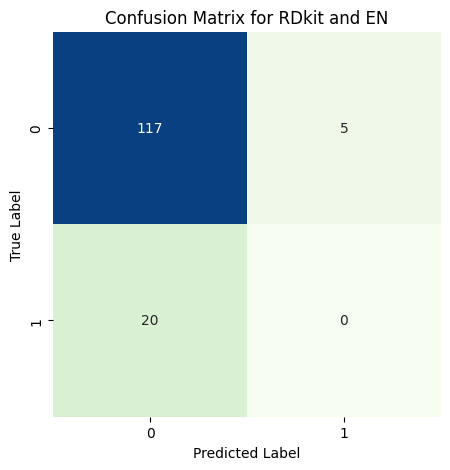

>0.794
>0.889
>0.868
>0.841
>0.884
>0.868
>0.852
>0.868
>0.847
>0.841
>0.915
>0.889
>0.841
>0.831
>0.799
Accuracy: 0.855 (0.032)
Best hyperparameters for RDkit and EX:
dense-bot: 238
dense_activation: tanh
num_dense_layers: 3
dense_0: 98
act_l1: tanh
dropout_0: 0.0
Optimizer: SGD
learning_rate: 1e-06
dense_1: 454
dropout_1: 0.3
dense_2: 146
dropout_2: 0.0
batch_size: 82
dense_3: 482
dropout_3: 0.5
dense_4: 260
dropout_4: 0.0


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 238)            │        64,022 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 98)             │        23,422 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 98)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 454)            │        44,946 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 454)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 146)            │        66,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 146)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,967 (777.21 KB)

 Trainable params: 198,967 (777.21 KB)

 Non-trainable params: 0 (0.00 B)

Saved model for RDkit and EX to Best_NNmodel_RDkit_EX.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8822 - loss: 0.5564  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8167 - loss: 0.5705 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8681 - loss: 0.5672 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8889 - loss: 0.5504
Binary-accuracy score for RDkit and EX:
Binary-accuracy score for training set: 0.87
Binary-accuracy score for test set: 0.82
Binary-accuracy score for valid set: 0.88
Binary-accuracy score for whole data set: 0.86
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Saved confusion matrix plot for RDkit and EX to NNconfusion_matrix_RDkit_EX.png


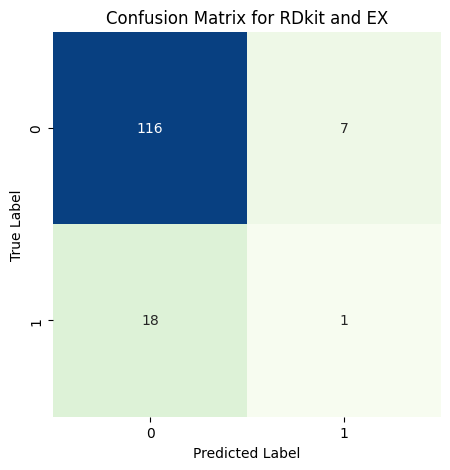

>0.836
>0.899
>0.862
>0.836
>0.873
>0.878
>0.884
>0.841
>0.862
>0.841
>0.841
>0.841
>0.873
>0.873
>0.878
Accuracy: 0.861 (0.020)
Best hyperparameters for RDkit and HE:
dense-bot: 244
dense_activation: relu
num_dense_layers: 1
dense_0: 104
act_l1: sigmoid
dropout_0: 0.2
Optimizer: Adam
learning_rate: 0.0001
dense_1: 226
dropout_1: 0.2
dense_2: 274
dropout_2: 0.3
batch_size: 66
dense_3: 308
dropout_3: 0.5
dense_4: 350
dropout_4: 0.3


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 244)            │        65,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 104)            │        25,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 104)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,221 (356.33 KB)

 Trainable params: 91,221 (356.33 KB)

 Non-trainable params: 0 (0.00 B)

Saved model for RDkit and HE to Best_NNmodel_RDkit_HE.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.6955 - loss: 0.6200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6881 - loss: 0.6378 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6786 - loss: 0.6565 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.7101 - loss: 0.6184
Binary-accuracy score for RDkit and HE:
Binary-accuracy score for training set: 0.67
Binary-accuracy score for test set: 0.70
Binary-accuracy score for valid set: 0.66
Binary-accuracy score for whole data set: 0.67
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Saved confusion matrix plot for RDkit and HE to NNconfusion_matrix_RDkit_HE.png


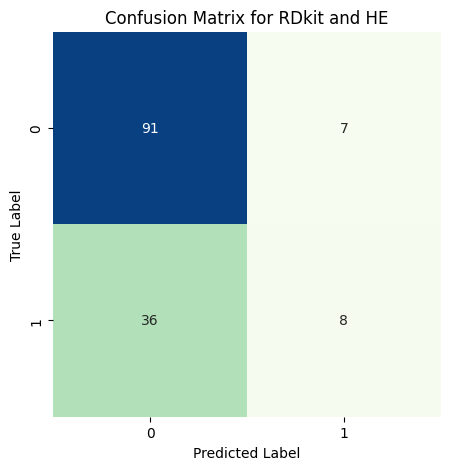

>0.640
>0.757
>0.667
>0.614
>0.677
>0.683
>0.725
>0.661
>0.661
>0.624
>0.656
>0.698
>0.651
>0.683
>0.667
Accuracy: 0.671 (0.035)
Best hyperparameters for RDkit and RES:
dense-bot: 674
dense_activation: relu
num_dense_layers: 3
dense_0: 160
act_l1: sigmoid
dropout_0: 0.1
Optimizer: SGD
learning_rate: 0.1
dense_1: 28
dropout_1: 0.0
dense_2: 28
dropout_2: 0.0
batch_size: 16


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 674)            │       181,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 160)            │       108,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │         4,508 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │           812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 294,655 (1.12 MB)

 Trainable params: 294,655 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for RDkit and RES to Best_NNmodel_RDkit_RES.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8148 - loss: 0.4805  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8240 - loss: 0.4656 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8342 - loss: 0.4490 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8493 - loss: 0.4244 
Binary-accuracy score for RDkit and RES:
Binary-accuracy score for training set: 0.81
Binary-accuracy score for test set: 0.84
Binary-accuracy score for valid set: 0.85
Binary-accuracy score for whole data set: 0.82
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Saved confusion matrix plot for RDkit and RES to NNconfusion_matrix_RDkit_RES.png


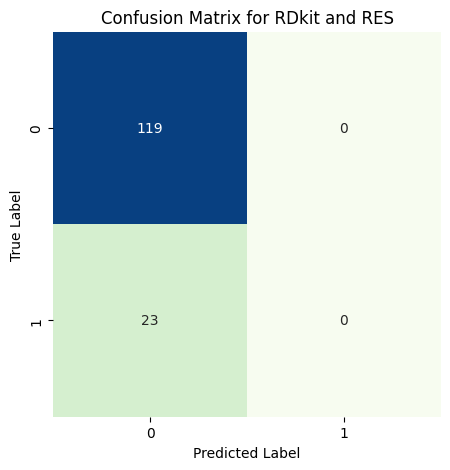

>0.836
>0.825
>0.847
>0.799
>0.799
>0.831
>0.857
>0.799
>0.804
>0.815
>0.825
>0.831
>0.799
>0.794
>0.857
Accuracy: 0.821 (0.021)
Best hyperparameters for RDkit and U:
dense-bot: 350
dense_activation: tanh
num_dense_layers: 3
dense_0: 466
act_l1: tanh
dropout_0: 0.5
Optimizer: SGD
learning_rate: 0.1
dense_1: 294
dropout_1: 0.0
dense_2: 260
dropout_2: 0.2
batch_size: 238
dense_3: 206
dropout_3: 0.1
dense_4: 52
dropout_4: 0.3


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 350)            │        94,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 466)            │       163,566 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 466)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 294)            │       137,298 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 294)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 260)            │        76,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 260)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           261 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 471,975 (1.80 MB)

 Trainable params: 471,975 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for RDkit and U to Best_NNmodel_RDkit_U.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8687 - loss: 0.3259   
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8525 - loss: 0.3892  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8002 - loss: 0.5046  
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8837 - loss: 0.3347
Binary-accuracy score for RDkit and U:
Binary-accuracy score for training set: 0.86
Binary-accuracy score for test set: 0.87
Binary-accuracy score for valid set: 0.80
Binary-accuracy score for whole data set: 0.85
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Saved confusion matrix plot for RDkit and U to NNconfusion_matrix_RDkit_U.png


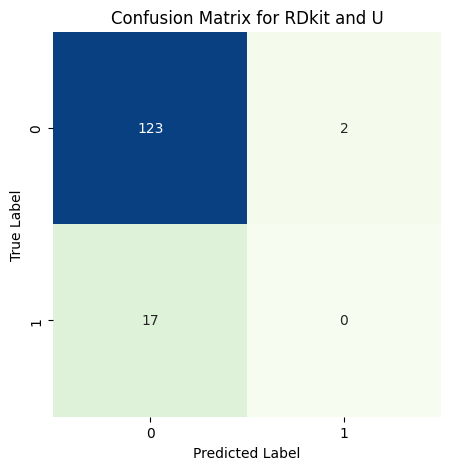

>0.836
>0.852
>0.873
>0.852
>0.847
>0.889
>0.862
>0.820
>0.862
>0.825
>0.857
>0.868
>0.825
>0.857
>0.852
Accuracy: 0.852 (0.018)
Best hyperparameters for ECFP and EN:
dense-bot: 314
dense_activation: tanh
num_dense_layers: 1
dense_0: 268
act_l1: sigmoid
dropout_0: 0.0
Optimizer: SGD
learning_rate: 0.1
dense_1: 220
dropout_1: 0.0
dense_2: 126
dropout_2: 0.0
batch_size: 116
dense_3: 470
dropout_3: 0.2
dense_4: 396
dropout_4: 0.1


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 314)            │       344,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 268)            │        84,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 268)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           269 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,833 (1.64 MB)

 Trainable params: 428,833 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for ECFP and EN to Best_NNmodel_ECFP_EN.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9573 - loss: 0.1138  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8514 - loss: 0.5507 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8349 - loss: 0.4876  
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9342 - loss: 0.2203
Binary-accuracy score for ECFP and EN:
Binary-accuracy score for training set: 0.96
Binary-accuracy score for test set: 0.84
Binary-accuracy score for valid set: 0.84
Binary-accuracy score for whole data set: 0.92
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Saved confusion matrix plot for ECFP and EN to NNconfusion_matrix_ECFP_EN.png


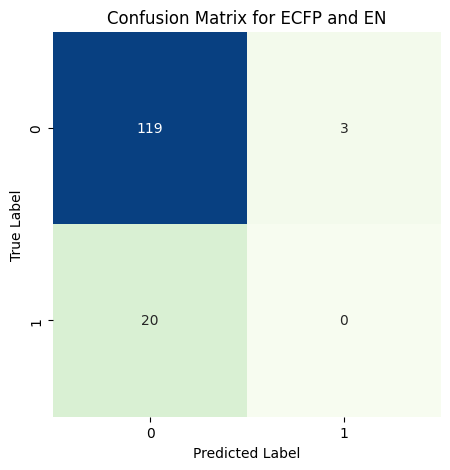

>0.804
>0.926
>0.968
>0.963
>0.952
>0.915
>0.942
>0.915
>0.905
>0.937
>0.926
>0.963
>0.894
>0.931
>0.899
Accuracy: 0.923 (0.039)
Best hyperparameters for ECFP and EX:
dense-bot: 74
dense_activation: tanh
num_dense_layers: 1
dense_0: 476
act_l1: relu
dropout_0: 0.5
Optimizer: Adam
learning_rate: 0.1
dense_1: 440
dropout_1: 0.3
dense_2: 484
dropout_2: 0.0
batch_size: 112
dense_3: 108
dropout_3: 0.0
dense_4: 110
dropout_4: 0.3


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 74)             │        81,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 476)            │        35,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 476)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           477 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,281 (458.13 KB)

 Trainable params: 117,281 (458.13 KB)

 Non-trainable params: 0 (0.00 B)

Saved model for ECFP and EX to Best_NNmodel_ECFP_EX.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8957 - loss: 0.3001  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8656 - loss: 0.4259 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8655 - loss: 0.4070 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.9086 - loss: 0.2869
Binary-accuracy score for ECFP and EX:
Binary-accuracy score for training set: 0.88
Binary-accuracy score for test set: 0.87
Binary-accuracy score for valid set: 0.88
Binary-accuracy score for whole data set: 0.88
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Saved confusion matrix plot for ECFP and EX to NNconfusion_matrix_ECFP_EX.png


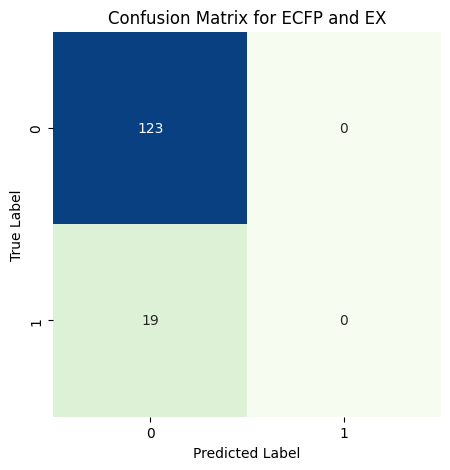

>0.868
>0.894
>0.899
>0.852
>0.884
>0.889
>0.889
>0.873
>0.884
>0.862
>0.868
>0.868
>0.873
>0.884
>0.905
Accuracy: 0.879 (0.014)


2024-11-20 01:47:55.899715: W tensorflow/core/data/root_dataset.cc:362] Optimization loop failed: CANCELLED: Operation was cancelled


Best hyperparameters for ECFP and HE:
dense-bot: 438
dense_activation: sigmoid
num_dense_layers: 1
dense_0: 92
act_l1: relu
dropout_0: 0.2
Optimizer: SGD
learning_rate: 0.01
dense_1: 58
dropout_1: 0.2
dense_2: 426
dropout_2: 0.3
batch_size: 152
dense_3: 122
dropout_3: 0.2
dense_4: 40
dropout_4: 0.2


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 438)            │       480,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 92)             │        40,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 92)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            93 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 520,529 (1.99 MB)

 Trainable params: 520,529 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for ECFP and HE to Best_NNmodel_ECFP_HE.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7164 - loss: 0.5962  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6139 - loss: 0.6502 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6660 - loss: 0.6636 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7060 - loss: 0.6182 
Binary-accuracy score for ECFP and HE:
Binary-accuracy score for training set: 0.71
Binary-accuracy score for test set: 0.63
Binary-accuracy score for valid set: 0.65
Binary-accuracy score for whole data set: 0.69
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Saved confusion matrix plot for ECFP and HE to NNconfusion_matrix_ECFP_HE.png


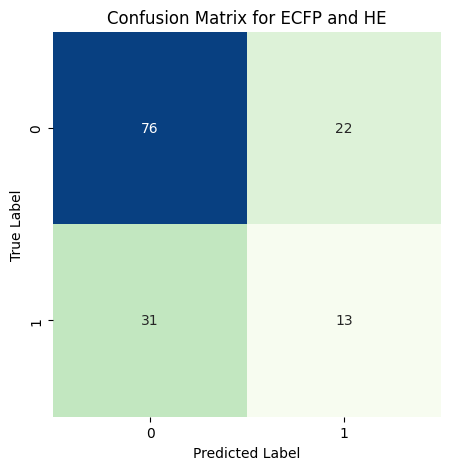

>0.619
>0.720
>0.688
>0.651
>0.751
>0.698
>0.741
>0.661
>0.672
>0.656
>0.688
>0.677
>0.693
>0.698
>0.672
Accuracy: 0.686 (0.033)
Best hyperparameters for ECFP and RES:
dense-bot: 314
dense_activation: tanh
num_dense_layers: 1
dense_0: 268
act_l1: sigmoid
dropout_0: 0.0
Optimizer: SGD
learning_rate: 0.1
dense_1: 220
dropout_1: 0.0
dense_2: 126
dropout_2: 0.0
batch_size: 116
dense_3: 470
dropout_3: 0.2
dense_4: 396
dropout_4: 0.1


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 314)            │       344,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 268)            │        84,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 268)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           269 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,833 (1.64 MB)

 Trainable params: 428,833 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for ECFP and RES to Best_NNmodel_ECFP_RES.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8396 - loss: 0.3366  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8452 - loss: 0.3684 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8660 - loss: 0.4066 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8687 - loss: 0.3302 
Binary-accuracy score for ECFP and RES:
Binary-accuracy score for training set: 0.84
Binary-accuracy score for test set: 0.85
Binary-accuracy score for valid set: 0.87
Binary-accuracy score for whole data set: 0.84
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Saved confusion matrix plot for ECFP and RES to NNconfusion_matrix_ECFP_RES.png


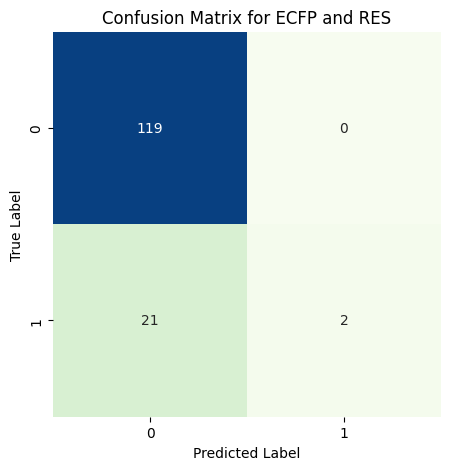

>0.852
>0.847
>0.873
>0.820
>0.825
>0.868
>0.873
>0.810
>0.825
>0.841
>0.841
>0.847
>0.820
>0.836
>0.873
Accuracy: 0.843 (0.020)
Best hyperparameters for ECFP and U:
dense-bot: 916
dense_activation: relu
num_dense_layers: 2
dense_0: 104
act_l1: tanh
dropout_0: 0.0
Optimizer: SGD
learning_rate: 0.1
dense_1: 474
dropout_1: 0.5
dense_2: 400
dropout_2: 0.3
batch_size: 204
dense_3: 356
dropout_3: 0.0
dense_4: 44
dropout_4: 0.5


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 916)            │     1,003,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 104)            │        95,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 104)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 474)            │        49,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 474)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,149,549 (4.39 MB)

 Trainable params: 1,149,549 (4.39 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for ECFP and U to Best_NNmodel_ECFP_U.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9522 - loss: 0.1319  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8481 - loss: 0.4346 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8129 - loss: 0.6168 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9178 - loss: 0.2372
Binary-accuracy score for ECFP and U:
Binary-accuracy score for training set: 0.94
Binary-accuracy score for test set: 0.85
Binary-accuracy score for valid set: 0.81
Binary-accuracy score for whole data set: 0.91
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Saved confusion matrix plot for ECFP and U to NNconfusion_matrix_ECFP_U.png


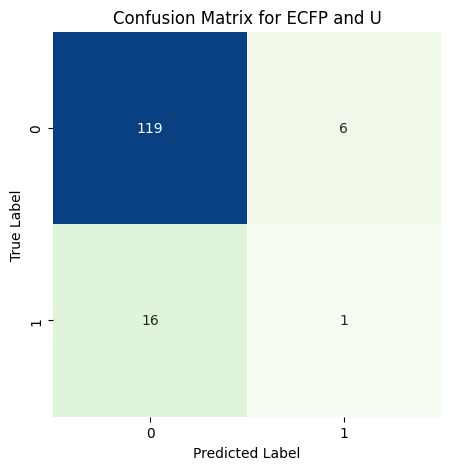

>0.836
>0.894
>0.931
>0.942
>0.926
>0.910
>0.905
>0.884
>0.926
>0.905
>0.921
>0.884
>0.884
>0.915
>0.926
Accuracy: 0.906 (0.026)
Best hyperparameters for FCFP and EN:
dense-bot: 66
dense_activation: relu
num_dense_layers: 2
dense_0: 390
act_l1: relu
dropout_0: 0.3
Optimizer: SGD
learning_rate: 0.001
dense_1: 184
dropout_1: 0.5
dense_2: 242
dropout_2: 0.0
batch_size: 250
dense_3: 488
dropout_3: 0.5
dense_4: 98
dropout_4: 0.2


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 66)             │        72,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 390)            │        26,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 184)            │        71,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 184)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           185 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,595 (666.39 KB)

 Trainable params: 170,595 (666.39 KB)

 Non-trainable params: 0 (0.00 B)

Saved model for FCFP and EN to Best_NNmodel_FCFP_EN.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8558 - loss: 0.6553  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8674 - loss: 0.6530 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8207 - loss: 0.6623 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8692 - loss: 0.6543 
Binary-accuracy score for FCFP and EN:
Binary-accuracy score for training set: 0.84
Binary-accuracy score for test set: 0.85
Binary-accuracy score for valid set: 0.82
Binary-accuracy score for whole data set: 0.84
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Saved confusion matrix plot for FCFP and EN to NNconfusion_matrix_FCFP_EN.png


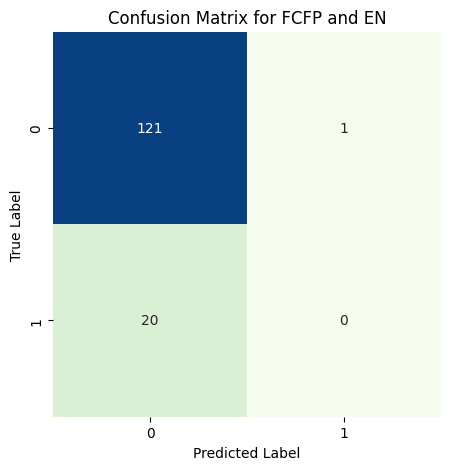

>0.810
>0.884
>0.836
>0.815
>0.847
>0.841
>0.841
>0.847
>0.836
>0.825
>0.878
>0.899
>0.804
>0.820
>0.788
Accuracy: 0.838 (0.030)
Best hyperparameters for FCFP and EX:
dense-bot: 728
dense_activation: relu
num_dense_layers: 2
dense_0: 398
act_l1: tanh
dropout_0: 0.3
Optimizer: Adam
learning_rate: 0.0001
dense_1: 372
dropout_1: 0.1
dense_2: 288
dropout_2: 0.2
batch_size: 30
dense_3: 386
dropout_3: 0.5
dense_4: 380
dropout_4: 0.0


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 728)            │       797,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 398)            │       290,142 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 398)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 372)            │       148,428 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 372)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           373 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,236,831 (4.72 MB)

 Trainable params: 1,236,831 (4.72 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for FCFP and EX to Best_NNmodel_FCFP_EX.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9746 - loss: 0.1027
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8619 - loss: 0.4349 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8813 - loss: 0.4332 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9482 - loss: 0.1839
Binary-accuracy score for FCFP and EX:
Binary-accuracy score for training set: 0.96
Binary-accuracy score for test set: 0.86
Binary-accuracy score for valid set: 0.89
Binary-accuracy score for whole data set: 0.93
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Saved confusion matrix plot for FCFP and EX to NNconfusion_matrix_FCFP_EX.png


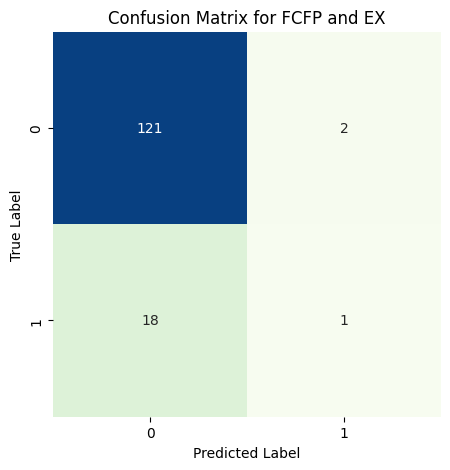

>0.868
>0.942
>0.968
>0.937
>0.942
>0.931
>0.921
>0.931
>0.926
>0.947
>0.931
>0.915
>0.926
>0.937
>0.947
Accuracy: 0.931 (0.021)


2024-11-20 12:51:04.898029: W tensorflow/core/data/root_dataset.cc:362] Optimization loop failed: CANCELLED: Operation was cancelled


Best hyperparameters for FCFP and HE:
dense-bot: 190
dense_activation: relu
num_dense_layers: 2
dense_0: 80
act_l1: relu
dropout_0: 0.1
Optimizer: SGD
learning_rate: 0.1
dense_1: 118
dropout_1: 0.1
dense_2: 402
dropout_2: 0.2
batch_size: 100
dense_3: 450
dropout_3: 0.2
dense_4: 460
dropout_4: 0.5


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 190)            │       208,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 80)             │        15,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 118)            │         9,558 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 118)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,197 (910.93 KB)

 Trainable params: 233,197 (910.93 KB)

 Non-trainable params: 0 (0.00 B)

Saved model for FCFP and HE to Best_NNmodel_FCFP_HE.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9724 - loss: 0.1073  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6359 - loss: 0.9029 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6998 - loss: 0.9042 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8753 - loss: 0.3422 
Binary-accuracy score for FCFP and HE:
Binary-accuracy score for training set: 0.98
Binary-accuracy score for test set: 0.64
Binary-accuracy score for valid set: 0.66
Binary-accuracy score for whole data set: 0.88
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Saved confusion matrix plot for FCFP and HE to NNconfusion_matrix_FCFP_HE.png


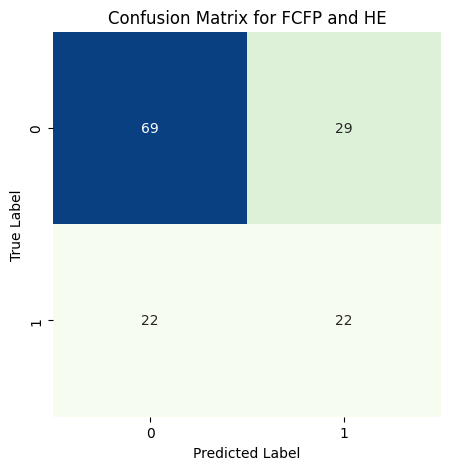

>0.624
>0.836
>0.979
>0.974
>0.989
>0.862
>0.899
>0.884
>0.905
>0.852
>0.868
>0.889
>0.868
>0.910
>0.868
Accuracy: 0.880 (0.082)
Best hyperparameters for FCFP and RES:
dense-bot: 350
dense_activation: tanh
num_dense_layers: 3
dense_0: 466
act_l1: tanh
dropout_0: 0.5
Optimizer: SGD
learning_rate: 0.1
dense_1: 294
dropout_1: 0.0
dense_2: 260
dropout_2: 0.2
batch_size: 238
dense_3: 206
dropout_3: 0.1
dense_4: 52
dropout_4: 0.3


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 350)            │       383,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 466)            │       163,566 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 466)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 294)            │       137,298 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 294)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 260)            │        76,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 260)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           261 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 761,425 (2.90 MB)

 Trainable params: 761,425 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for FCFP and RES to Best_NNmodel_FCFP_RES.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8500 - loss: 0.4327  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8584 - loss: 0.5428 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8683 - loss: 0.7966 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8726 - loss: 0.4610
Binary-accuracy score for FCFP and RES:
Binary-accuracy score for training set: 0.85
Binary-accuracy score for test set: 0.86
Binary-accuracy score for valid set: 0.87
Binary-accuracy score for whole data set: 0.85
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
Saved confusion matrix plot for FCFP and RES to NNconfusion_matrix_FCFP_RES.png


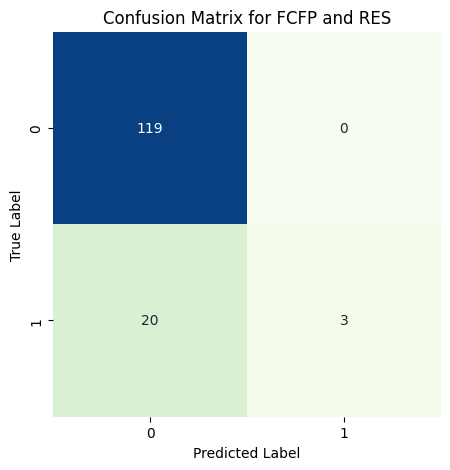

>0.857
>0.857
>0.884
>0.836
>0.825
>0.889
>0.873
>0.815
>0.841
>0.841
>0.852
>0.873
>0.815
>0.841
>0.878
Accuracy: 0.852 (0.023)


IOStream.flush timed out


Best hyperparameters for FCFP and U:
dense-bot: 384
dense_activation: relu
num_dense_layers: 1
dense_0: 398
act_l1: relu
dropout_0: 0.1
Optimizer: Adam
learning_rate: 0.1
dense_1: 272
dropout_1: 0.1
dense_2: 298
dropout_2: 0.1
batch_size: 152
dense_3: 220
dropout_3: 0.0
dense_4: 278
dropout_4: 0.0


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 384)            │       420,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 398)            │       153,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 398)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           399 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 574,493 (2.19 MB)

 Trainable params: 574,493 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for FCFP and U to Best_NNmodel_FCFP_U.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8950 - loss: 0.3369
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8711 - loss: 0.4332 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8002 - loss: 0.6023 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8953 - loss: 0.3900
Binary-accuracy score for FCFP and U:
Binary-accuracy score for training set: 0.87
Binary-accuracy score for test set: 0.88
Binary-accuracy score for valid set: 0.80
Binary-accuracy score for whole data set: 0.86
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Saved confusion matrix plot for FCFP and U to NNconfusion_matrix_FCFP_U.png


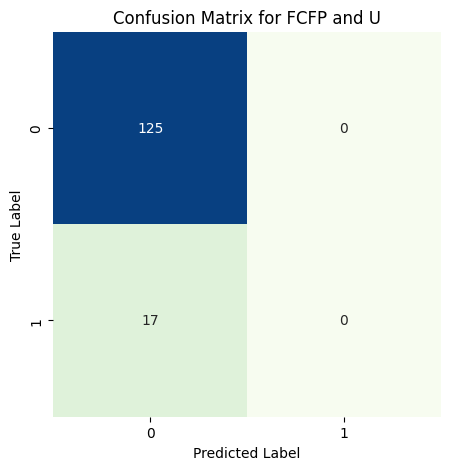

>0.841
>0.884
>0.873
>0.868
>0.857
>0.899
>0.841
>0.831
>0.894
>0.857
>0.868
>0.884
>0.825
>0.873
>0.873
Accuracy: 0.865 (0.021)
Best hyperparameters for MACCS and EN:
dense-bot: 244
dense_activation: relu
num_dense_layers: 1
dense_0: 104
act_l1: sigmoid
dropout_0: 0.2
Optimizer: Adam
learning_rate: 0.0001
dense_1: 226
dropout_1: 0.2
dense_2: 274
dropout_2: 0.3
batch_size: 66
dense_3: 308
dropout_3: 0.5
dense_4: 350
dropout_4: 0.3


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 244)            │        58,316 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 104)            │        25,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 104)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,901 (327.74 KB)

 Trainable params: 83,901 (327.74 KB)

 Non-trainable params: 0 (0.00 B)

Saved model for MACCS and EN to Best_NNmodel_MACCS_EN.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9043 - loss: 0.2409  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8514 - loss: 0.4170 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8429 - loss: 0.4258 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9048 - loss: 0.2754 
Binary-accuracy score for MACCS and EN:
Binary-accuracy score for training set: 0.89
Binary-accuracy score for test set: 0.84
Binary-accuracy score for valid set: 0.85
Binary-accuracy score for whole data set: 0.88
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Saved confusion matrix plot for MACCS and EN to NNconfusion_matrix_MACCS_EN.png


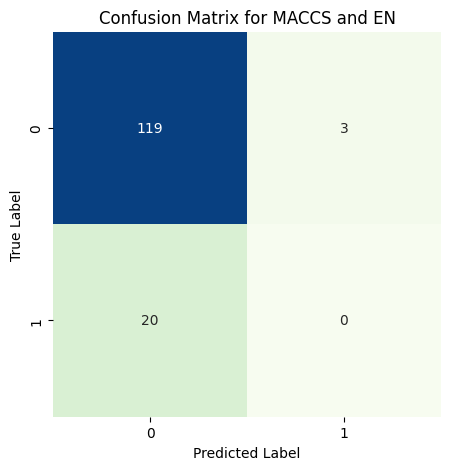

>0.815
>0.899
>0.905
>0.878
>0.894
>0.868
>0.878
>0.894
>0.873
>0.878
>0.889
>0.926
>0.847
>0.873
>0.857
Accuracy: 0.878 (0.025)
Best hyperparameters for MACCS and EX:
dense-bot: 716
dense_activation: tanh
num_dense_layers: 2
dense_0: 354
act_l1: tanh
dropout_0: 0.3
Optimizer: Adam
learning_rate: 1e-06
dense_1: 362
dropout_1: 0.1
dense_2: 502
dropout_2: 0.5
batch_size: 46
dense_3: 478
dropout_3: 0.2
dense_4: 434
dropout_4: 0.1


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 716)            │       171,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 354)            │       253,818 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 354)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 362)            │       128,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 362)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 553,815 (2.11 MB)

 Trainable params: 553,815 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for MACCS and EX to Best_NNmodel_MACCS_EX.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8851 - loss: 0.4328  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8656 - loss: 0.4531 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8655 - loss: 0.4152 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8973 - loss: 0.4341 
Binary-accuracy score for MACCS and EX:
Binary-accuracy score for training set: 0.87
Binary-accuracy score for test set: 0.87
Binary-accuracy score for valid set: 0.88
Binary-accuracy score for whole data set: 0.87
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Saved confusion matrix plot for MACCS and EX to NNconfusion_matrix_MACCS_EX.png


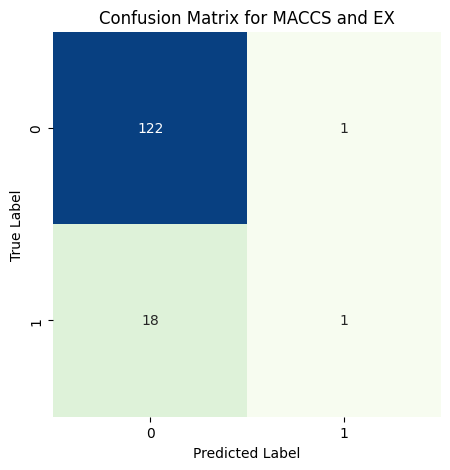

>0.862
>0.899
>0.878
>0.847
>0.862
>0.884
>0.884
>0.862
>0.868
>0.852
>0.847
>0.857
>0.852
>0.899
>0.894
Accuracy: 0.870 (0.018)
Best hyperparameters for MACCS and HE:
dense-bot: 600
dense_activation: tanh
num_dense_layers: 2
dense_0: 222
act_l1: sigmoid
dropout_0: 0.5
Optimizer: Adam
learning_rate: 0.001
dense_1: 146
dropout_1: 0.1
dense_2: 294
dropout_2: 0.0
batch_size: 140
dense_3: 272
dropout_3: 0.3
dense_4: 134
dropout_4: 0.5


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 600)            │       143,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 222)            │       133,422 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 222)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 146)            │        32,558 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 146)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,527 (1.18 MB)

 Trainable params: 309,527 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for MACCS and HE to Best_NNmodel_MACCS_HE.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6930 - loss: 0.6003  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6257 - loss: 0.6632 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6949 - loss: 0.6307 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6829 - loss: 0.6189 
Binary-accuracy score for MACCS and HE:
Binary-accuracy score for training set: 0.68
Binary-accuracy score for test set: 0.65
Binary-accuracy score for valid set: 0.69
Binary-accuracy score for whole data set: 0.68
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Saved confusion matrix plot for MACCS and HE to NNconfusion_matrix_MACCS_HE.png


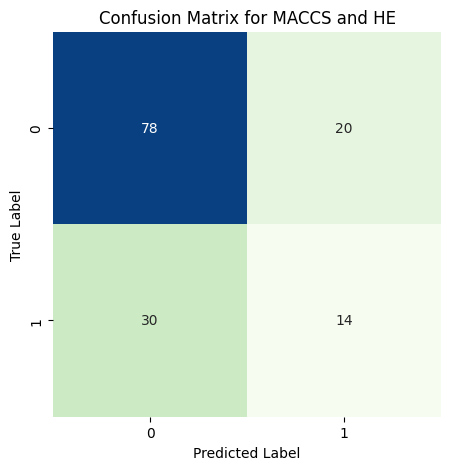

>0.630
>0.746
>0.672
>0.635
>0.704
>0.672
>0.709
>0.698
>0.672
>0.635
>0.672
>0.672
>0.714
>0.656
>0.672
Accuracy: 0.677 (0.031)
Best hyperparameters for MACCS and RES:
dense-bot: 674
dense_activation: relu
num_dense_layers: 3
dense_0: 160
act_l1: sigmoid
dropout_0: 0.1
Optimizer: SGD
learning_rate: 0.1
dense_1: 28
dropout_1: 0.0
dense_2: 28
dropout_2: 0.0
batch_size: 16


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 674)            │       161,086 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 160)            │       108,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │         4,508 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │           812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,435 (1.05 MB)

 Trainable params: 274,435 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for MACCS and RES to Best_NNmodel_MACCS_RES.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8562 - loss: 0.3428  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8512 - loss: 0.3835 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8709 - loss: 0.4431 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.8703 - loss: 0.3551
Binary-accuracy score for MACCS and RES:
Binary-accuracy score for training set: 0.84
Binary-accuracy score for test set: 0.87
Binary-accuracy score for valid set: 0.87
Binary-accuracy score for whole data set: 0.85
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Saved confusion matrix plot for MACCS and RES to NNconfusion_matrix_MACCS_RES.png


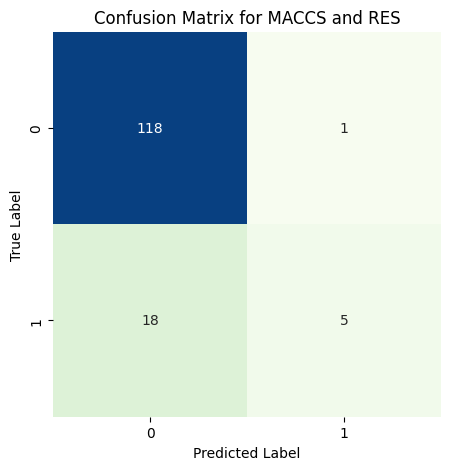

>0.868
>0.857
>0.889
>0.825
>0.820
>0.873
>0.868
>0.841
>0.841
>0.836
>0.852
>0.862
>0.820
>0.836
>0.889
Accuracy: 0.852 (0.022)
Best hyperparameters for MACCS and U:
dense-bot: 716
dense_activation: tanh
num_dense_layers: 2
dense_0: 354
act_l1: tanh
dropout_0: 0.3
Optimizer: Adam
learning_rate: 1e-06
dense_1: 362
dropout_1: 0.1
dense_2: 502
dropout_2: 0.5
batch_size: 46
dense_3: 478
dropout_3: 0.2
dense_4: 434
dropout_4: 0.1


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 716)            │       171,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 354)            │       253,818 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 354)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 362)            │       128,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 362)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 553,815 (2.11 MB)

 Trainable params: 553,815 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for MACCS and U to Best_NNmodel_MACCS_U.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8478 - loss: 0.4800  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8517 - loss: 0.4667 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7958 - loss: 0.5392 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8649 - loss: 0.4739 
Binary-accuracy score for MACCS and U:
Binary-accuracy score for training set: 0.83
Binary-accuracy score for test set: 0.85
Binary-accuracy score for valid set: 0.80
Binary-accuracy score for whole data set: 0.83
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Saved confusion matrix plot for MACCS and U to NNconfusion_matrix_MACCS_U.png


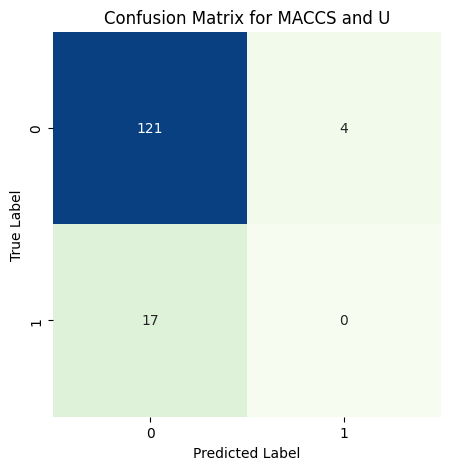

>0.831
>0.836
>0.862
>0.820
>0.810
>0.878
>0.820
>0.804
>0.852
>0.804
>0.841
>0.857
>0.799
>0.831
>0.831
Accuracy: 0.832 (0.023)
Best hyperparameters for All and EN:
dense-bot: 314
dense_activation: tanh
num_dense_layers: 1
dense_0: 268
act_l1: sigmoid
dropout_0: 0.0
Optimizer: SGD
learning_rate: 0.1
dense_1: 220
dropout_1: 0.0
dense_2: 126
dropout_2: 0.0
batch_size: 116
dense_3: 470
dropout_3: 0.2
dense_4: 396
dropout_4: 0.1


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 314)            │       779,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 268)            │        84,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 268)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           269 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 864,665 (3.30 MB)

 Trainable params: 864,665 (3.30 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for All and EN to Best_NNmodel_All_EN.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9010 - loss: 0.2306  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8594 - loss: 0.4660 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8349 - loss: 0.4697 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9056 - loss: 0.2690 
Binary-accuracy score for All and EN:
Binary-accuracy score for training set: 0.90
Binary-accuracy score for test set: 0.85
Binary-accuracy score for valid set: 0.84
Binary-accuracy score for whole data set: 0.88
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Saved confusion matrix plot for All and EN to NNconfusion_matrix_All_EN.png


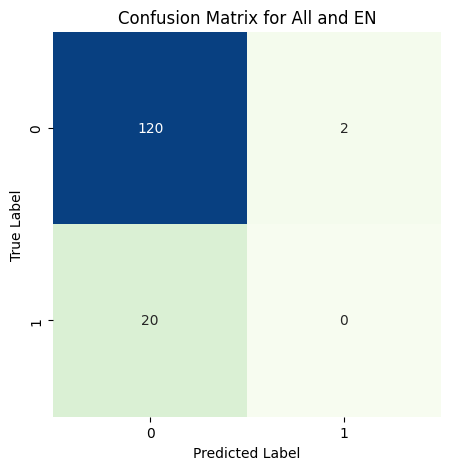

>0.815
>0.889
>0.915
>0.889
>0.899
>0.884
>0.873
>0.894
>0.878
>0.878
>0.905
>0.921
>0.852
>0.889
>0.841
Accuracy: 0.881 (0.027)
Best hyperparameters for All and EX:
dense-bot: 800
dense_activation: relu
num_dense_layers: 2
dense_0: 84
act_l1: relu
dropout_0: 0.1
Optimizer: Adam
learning_rate: 1e-05
dense_1: 144
dropout_1: 0.0
dense_2: 42
dropout_2: 0.5
batch_size: 132
dense_3: 54
dropout_3: 0.2
dense_4: 340
dropout_4: 0.5


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 800)            │     1,987,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        67,284 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 144)            │        12,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,066,869 (7.88 MB)

 Trainable params: 2,066,869 (7.88 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for All and EX to Best_NNmodel_All_EX.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8447 - loss: 0.6472  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8324 - loss: 0.6484 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8655 - loss: 0.6423 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8608 - loss: 0.6465
Binary-accuracy score for All and EX:
Binary-accuracy score for training set: 0.83
Binary-accuracy score for test set: 0.82
Binary-accuracy score for valid set: 0.88
Binary-accuracy score for whole data set: 0.84
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Saved confusion matrix plot for All and EX to NNconfusion_matrix_All_EX.png


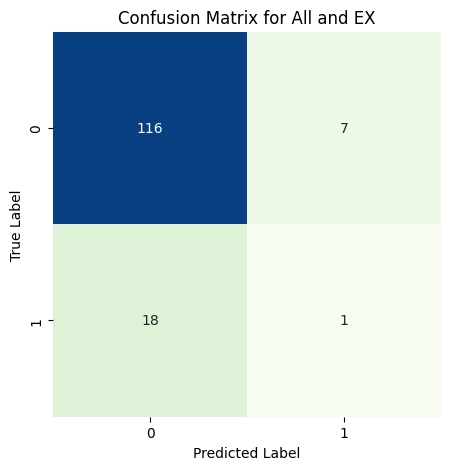

>0.852
>0.862
>0.831
>0.810
>0.831
>0.878
>0.857
>0.831
>0.831
>0.788
>0.831
>0.825
>0.825
>0.852
>0.852
Accuracy: 0.837 (0.022)
Best hyperparameters for All and HE:
dense-bot: 732
dense_activation: relu
num_dense_layers: 2
dense_0: 232
act_l1: relu
dropout_0: 0.0
Optimizer: SGD
learning_rate: 0.01
dense_1: 394
dropout_1: 0.2
dense_2: 398
dropout_2: 0.0
batch_size: 226
dense_3: 250
dropout_3: 0.1
dense_4: 188
dropout_4: 0.0


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 732)            │     1,818,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 232)            │       170,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 232)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 394)            │        91,802 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 394)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           395 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,080,541 (7.94 MB)

 Trainable params: 2,080,541 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for All and HE to Best_NNmodel_All_HE.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8308 - loss: 0.4498
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6977 - loss: 0.6205 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7328 - loss: 0.6160 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7997 - loss: 0.5086
Binary-accuracy score for All and HE:
Binary-accuracy score for training set: 0.85
Binary-accuracy score for test set: 0.70
Binary-accuracy score for valid set: 0.70
Binary-accuracy score for whole data set: 0.80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Saved confusion matrix plot for All and HE to NNconfusion_matrix_All_HE.png


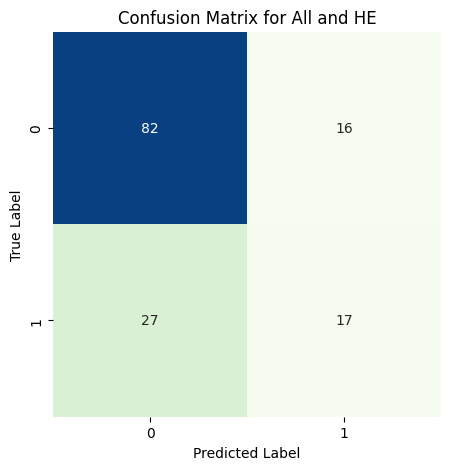

>0.656
>0.825
>0.799
>0.815
>0.915
>0.804
>0.815
>0.778
>0.825
>0.788
>0.788
>0.815
>0.810
>0.820
>0.778
Accuracy: 0.802 (0.050)
Best hyperparameters for All and RES:
dense-bot: 716
dense_activation: tanh
num_dense_layers: 2
dense_0: 354
act_l1: tanh
dropout_0: 0.3
Optimizer: Adam
learning_rate: 1e-06
dense_1: 362
dropout_1: 0.1
dense_2: 502
dropout_2: 0.5
batch_size: 46
dense_3: 478
dropout_3: 0.2
dense_4: 434
dropout_4: 0.1


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 716)            │     1,778,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 354)            │       253,818 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 354)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 362)            │       128,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 362)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,161,235 (8.24 MB)

 Trainable params: 2,161,235 (8.24 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for All and RES to Best_NNmodel_All_RES.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8422 - loss: 0.3325
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8452 - loss: 0.3549 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8714 - loss: 0.4025 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8704 - loss: 0.3334
Binary-accuracy score for All and RES:
Binary-accuracy score for training set: 0.84
Binary-accuracy score for test set: 0.85
Binary-accuracy score for valid set: 0.87
Binary-accuracy score for whole data set: 0.85
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Saved confusion matrix plot for All and RES to NNconfusion_matrix_All_RES.png


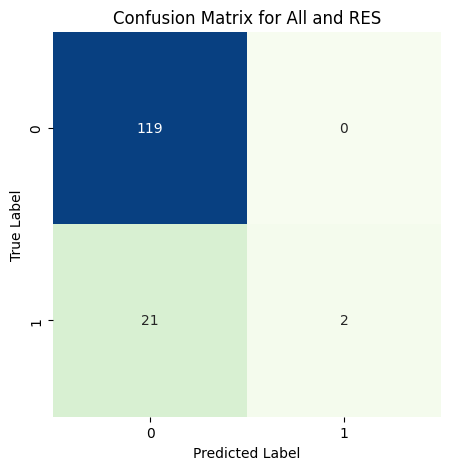

>0.857
>0.847
>0.878
>0.825
>0.820
>0.868
>0.878
>0.810
>0.831
>0.841
>0.847
>0.847
>0.820
>0.836
>0.878
Accuracy: 0.846 (0.022)
Best hyperparameters for All and U:
dense-bot: 292
dense_activation: relu
num_dense_layers: 1
dense_0: 232
act_l1: tanh
dropout_0: 0.3
Optimizer: SGD
learning_rate: 0.1
dense_1: 132
dropout_1: 0.1
dense_2: 426
dropout_2: 0.2
batch_size: 202
dense_3: 150
dropout_3: 0.5
dense_4: 184
dropout_4: 0.3


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 292)            │       725,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 232)            │        67,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 232)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           233 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 793,537 (3.03 MB)

 Trainable params: 793,537 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for All and U to Best_NNmodel_All_U.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8974 - loss: 0.2265
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8675 - loss: 0.3977 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8054 - loss: 0.6034 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8982 - loss: 0.2768
Binary-accuracy score for All and U:
Binary-accuracy score for training set: 0.89
Binary-accuracy score for test set: 0.87
Binary-accuracy score for valid set: 0.80
Binary-accuracy score for whole data set: 0.87
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Saved confusion matrix plot for All and U to NNconfusion_matrix_All_U.png


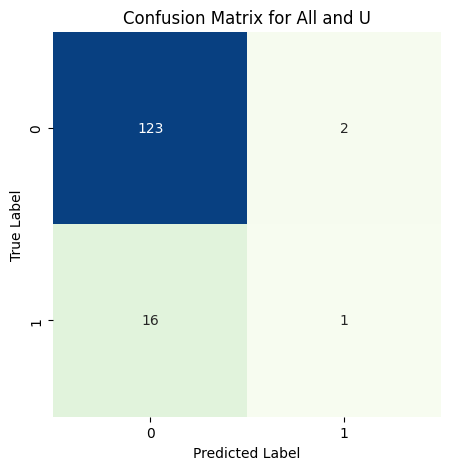

>0.836
>0.873
>0.905
>0.862
>0.878
>0.910
>0.884
>0.841
>0.878
>0.841
>0.878
>0.868
>0.841
>0.889
>0.878
Accuracy: 0.871 (0.022)


In [ ]:
# List of feature types and corresponding labels
feature_types = {"RDkit": X_rdkit, "ECFP": X_ECFP6, "FCFP": X_FCFP6, "MACCS": X_MACCS, "All": X_All}
label_types = {"EN": Yen, "EX": Yex, "HE": Yhe, "RES": Yres, "U": Yu}

# Loop through feature and label combinations
for feature_name, feature_data in feature_types.items():
    for label_name, label_data in label_types.items():

        # Define train-test split for the current feature-label pair
        X_train, X_res, y_train, y_res = train_test_split(feature_data, label_data, train_size=0.7, random_state=42)
        X_valid, X_test, y_valid, y_test = train_test_split(X_res, y_res, test_size=0.5, random_state=42)

        # Initialize the NNHyperModel class with the correct input shape
        input_shape = feature_data.shape[1]
        hypermodel = NNHyperModel(input_shape=input_shape)

        # Define the Bayesian Optimization tuner
        tuner_bo = BayesianOptimization(
            hypermodel,
            objective=kt.Objective('val_accuracy', direction='max'),
            max_trials=50,
            overwrite=True,
            executions_per_trial=3,
            directory='my_dir',          #when running more than one notebook
            project_name='my_project',   #when running more than one notebook
            seed=42
        )

        # Search for the best hyperparameters
        tuner_bo.search(X_train, y_train,
                        validation_data=(X_valid, y_valid),
                        epochs=500, verbose=0,
                        callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=5,
                                                                    restore_best_weights=True)] #Early stopping halts training when the model stops improving, which helps prevent overfitting
        )

        # Get the best hyperparameters
        best_params = tuner_bo.get_best_hyperparameters(num_trials=1)[0]

        # Print the best hyperparameters
        print(f"Best hyperparameters for {feature_name} and {label_name}:")
        for param, value in best_params.values.items():
            print(f"{param}: {value}")

        # Get the best model and print the summary
        best_model = tuner_bo.get_best_models(num_models=1)[0]
        best_model.summary()  # Print model summary

        # Save the model with the actual feature and label names in the filename
        model_filename = f"Best_NNmodel_{feature_name}_{label_name}.keras"
        best_model.save(model_filename)
        print(f"Saved model for {feature_name} and {label_name} to {model_filename}")


        # Evaluate the model on the training, test, validation, and whole datasets
        _, acc_train = best_model.evaluate(X_train, y_train)
        _, acc_test  = best_model.evaluate(X_test, y_test)
        _, acc_valid = best_model.evaluate(X_valid, y_valid)
        _, acc_whole = best_model.evaluate(feature_data, label_data)  # Fixed here

        # Print the results
        print(f"Binary-accuracy score for {feature_name} and {label_name}:")
        print("Binary-accuracy score for training set: %.2f" % acc_train)
        print("Binary-accuracy score for test set: %.2f" % acc_test)
        print("Binary-accuracy score for valid set: %.2f" % acc_valid)
        print("Binary-accuracy score for whole data set: %.2f" % acc_whole)


        # Predict the labels for the test data
        y_pred = (best_model.predict(X_test) > 0.5).astype("int32")  # Binary classification threshold

        # Calculate the confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot the confusion matrix using seaborn heatmap
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu', cbar=False)
        plt.title(f'Confusion Matrix for {feature_name} and {label_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        # Save the plot
        plot_filename = f"NNconfusion_matrix_{feature_name}_{label_name}.png"
        plt.savefig(plot_filename)
        print(f"Saved confusion matrix plot for {feature_name} and {label_name} to {plot_filename}")
        # Show the plot
        plt.show()

        # Evalaute model
        results = evaluate_model(feature_data, label_data)
        # Summarize performance
        print('Accuracy: %.3f (%.3f)' % (mean(results), std(results)))

In [ ]:
import os
from sklearn.metrics import recall_score, f1_score, precision_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score

In [ ]:
# Path to the folder where model files are saved
model_folder = './Best_NNmodel'
# Path to save plots
plot_save_folder = './NN_Curves'
os.makedirs(plot_save_folder, exist_ok=True)  # Create the directory if it doesn't exist

# List of feature types and corresponding labels
feature_types = {"RDkit": X_rdkit, "ECFP": X_ECFP6, "FCFP": X_FCFP6, "MACCS": X_MACCS, "All": X_All}
label_types = {"EN": Yen, "EX": Yex, "HE": Yhe, "RES": Yres, "U": Yu}

# Create a list to store metrics
metrics_list = []

In [ ]:
# Loop through feature and label combinations
for feature_name, feature_data in feature_types.items():
    for label_name, label_data in label_types.items():

        # Define train-test split for the current feature-label pair
        X_train, X_res, y_train, y_res = train_test_split(feature_data, label_data, train_size=0.7, random_state=42)
        X_valid, X_test, y_valid, y_test = train_test_split(X_res, y_res, test_size=0.5, random_state=42)

        # Directly map X_train index to the CAS column in df_finalized
        train_indices = df_finalized.loc[X_train.index, 'CAS']
        valid_indices = df_finalized.loc[X_valid.index, 'CAS']
        test_indices = df_finalized.loc[X_test.index, 'CAS']

        # Construct model filename based on feature and label names
        model_filename = f"Best_NNmodel_{feature_name}_{label_name}.keras"
        model_path = os.path.join(model_folder, model_filename)

        # Check if the model file exists before loading
        if os.path.exists(model_path):
            # Load the model
            model = tf.keras.models.load_model(model_path)

            # Make predictions on the training, validation, and test sets
            y_train_pred_prob = model.predict(X_train)
            y_valid_pred_prob = model.predict(X_valid)
            y_test_pred_prob = model.predict(X_test)

            # Convert probabilities to binary predictions
            y_train_pred = (y_train_pred_prob > 0.5).astype("int32")
            y_valid_pred = (y_valid_pred_prob > 0.5).astype("int32")
            y_test_pred = (y_test_pred_prob > 0.5).astype("int32")

            # Calculate metrics for training set
            train_recall = recall_score(y_train, y_train_pred, average='binary')
            train_f1_weighted = f1_score(y_train, y_train_pred, average='weighted')
            train_precision = precision_score(y_train, y_train_pred, average='binary')
            train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
            train_pr_auc = average_precision_score(y_train, y_train_pred_prob)

            # Calculate metrics for validation set
            valid_recall = recall_score(y_valid, y_valid_pred, average='binary')
            valid_f1_weighted = f1_score(y_valid, y_valid_pred, average='weighted')
            valid_precision = precision_score(y_valid, y_valid_pred, average='binary')
            valid_roc_auc = roc_auc_score(y_valid, y_valid_pred_prob)
            valid_pr_auc = average_precision_score(y_valid, y_valid_pred_prob)

            # Calculate metrics for test set
            test_recall = recall_score(y_test, y_test_pred, average='binary')
            test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
            test_precision = precision_score(y_test, y_test_pred, average='binary')
            test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
            test_pr_auc = average_precision_score(y_test, y_test_pred_prob)

            # Append metrics to the list
            metrics_list.append({
                'Model': model_filename,
                'Feature Type': feature_name,
                'Label Type': label_name,
                'Train_chem': train_indices.tolist(),
                'Validation_chem': valid_indices.tolist(),
                'Test_chem': test_indices.tolist(),
                'true Train': y_train.tolist(),
                'true Validation': y_valid.tolist(),
                'true Test': y_test.tolist(),
                'Train prob': y_train_pred_prob.tolist(),
                'Validation prob': y_valid_pred_prob.tolist(),
                'Test prob': y_test_pred_prob.tolist(),
                'Train Recall': train_recall,
                'Train F1 Score (Weighted)': train_f1_weighted,
                'Train Precision': train_precision,
                'Train ROC AUC': train_roc_auc,
                'Validation Recall': valid_recall,
                'Validation F1 Score (Weighted)': valid_f1_weighted,
                'Validation Precision': valid_precision,
                'Validation ROC AUC': valid_roc_auc,
                'Test Recall': test_recall,
                'Test F1 Score (Weighted)': test_f1_weighted,
                'Test Precision': test_precision,
                'Test ROC AUC': test_roc_auc
            })

# Convert the list to a DataFrame and save as CSV
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv('NN_model_metrics.csv', index=False)
metrics_df.info()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

/home/chen.chiyun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chen.chiyun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chen.chiyun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chen.chiyun/.local/lib/py

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Model                           25 non-null     object 
 1   Feature Type                    25 non-null     object 
 2   Label Type                      25 non-null     object 
 3   Train_chem                      25 non-null     object 
 4   Validation_chem                 25 non-null     object 
 5   Test_chem                       25 non-null     object 
 6   true Train                      25 non-null     object 
 7   true Validation                 25 non-null     object 
 8   true Test                       25 non-null     object 
 9   Train prob                      25 non-null     object 
 10  Validation prob                 25 non-null     object 
 11  Test prob                       25 non-null     object 
 12  

## Scenario II: Only molecular descriptor features as input

In [ ]:
# X_rdkit: X_rdkit_descrs_scal
X_rdkit = X_rdkit_descrs_scal
# X_ECFP6: ECFP6_descrs
X_ECFP6 = ECFP6_descrs.reset_index(drop=True)
# X_FCFP6: FCFP6_descrs
X_FCFP6 = FCFP6_descrs.reset_index(drop=True)
# X_MACCS: MACCS_descrs
X_MACCS = MACCS_descrs.reset_index(drop=True)
# X_All: four descriptors
X_All = pd.concat([X_rdkit_descrs_scal.reset_index(drop=True), ECFP6_descrs.reset_index(drop=True), FCFP6_descrs.reset_index(drop=True), MACCS_descrs.reset_index(drop=True)], axis = 1)

# Check the sample size

In [ ]:
print(X_rdkit.shape)
print(X_ECFP6.shape)
print(X_FCFP6.shape)
print(X_MACCS.shape)
print(X_All.shape)

(945, 197)
(945, 1024)
(945, 1024)
(945, 167)
(945, 2412)


## Named X and Y

In [ ]:
feature_types = ['X_rdkit', 'X_ECFP6', 'X_FCFP6', 'X_MACCS', 'X_All']

In [ ]:
label_types = ['Yen', 'Yex', 'Yhe', 'Yres', 'Yu']

Best hyperparameters for RDkit and EN:
dense-bot: 674
dense_activation: relu
num_dense_layers: 3
dense_0: 160
act_l1: sigmoid
dropout_0: 0.1
Optimizer: SGD
learning_rate: 0.1
dense_1: 28
dropout_1: 0.0
dense_2: 28
dropout_2: 0.0
batch_size: 16


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 674)            │       133,452 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 160)            │       108,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │         4,508 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │           812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,801 (964.07 KB)

 Trainable params: 246,801 (964.07 KB)

 Non-trainable params: 0 (0.00 B)

Saved model for RDkit and EN to best_QSARmodel_RDkit_EN.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8652 - loss: 0.4042  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8710 - loss: 0.3910 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8127 - loss: 0.5233 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.8733 - loss: 0.3858
Binary-accuracy score for RDkit and EN:
Binary-accuracy score for training set: 0.85
Binary-accuracy score for test set: 0.86
Binary-accuracy score for valid set: 0.82
Binary-accuracy score for whole data set: 0.84
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Saved confusion matrix plot for RDkit and EN to QSARconfusion_matrix_RDkit_EN.png


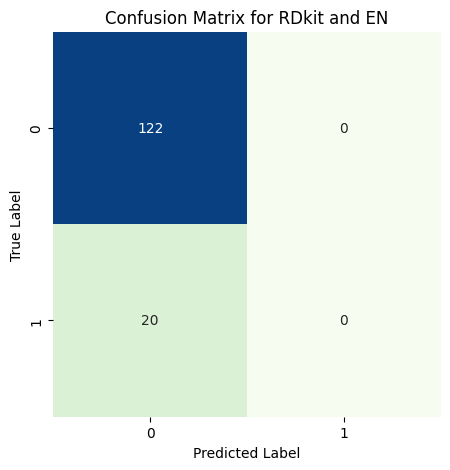

>0.810
>0.889
>0.857
>0.810
>0.852
>0.852
>0.836
>0.857
>0.841
>0.831
>0.889
>0.899
>0.810
>0.831
>0.788
Accuracy: 0.843 (0.031)
Best hyperparameters for RDkit and EX:
dense-bot: 104
dense_activation: relu
num_dense_layers: 2
dense_0: 436
act_l1: relu
dropout_0: 0.5
Optimizer: SGD
learning_rate: 1e-05
dense_1: 224
dropout_1: 0.5
dense_2: 148
dropout_2: 0.1
batch_size: 248
dense_3: 284
dropout_3: 0.2
dense_4: 94
dropout_4: 0.5


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 104)            │        20,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 436)            │        45,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 436)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 224)            │        97,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,485 (642.52 KB)

 Trainable params: 164,485 (642.52 KB)

 Non-trainable params: 0 (0.00 B)

Saved model for RDkit and EX to best_QSARmodel_RDkit_EX.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8684 - loss: 0.6713  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8524 - loss: 0.6693 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8655 - loss: 0.6717 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8918 - loss: 0.6686 
Binary-accuracy score for RDkit and EX:
Binary-accuracy score for training set: 0.86
Binary-accuracy score for test set: 0.86
Binary-accuracy score for valid set: 0.88
Binary-accuracy score for whole data set: 0.86
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Saved confusion matrix plot for RDkit and EX to QSARconfusion_matrix_RDkit_EX.png


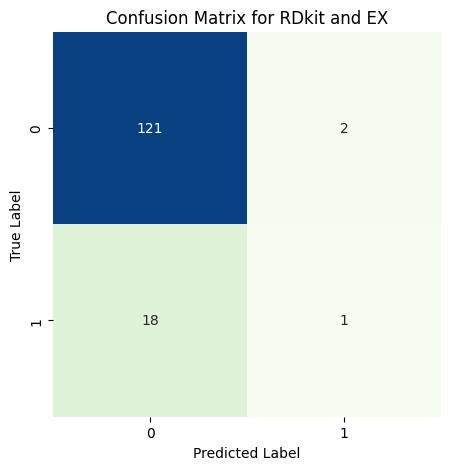

>0.873
>0.873
>0.862
>0.836
>0.878
>0.873
>0.878
>0.873
>0.862
>0.836
>0.847
>0.857
>0.852
>0.884
>0.884
Accuracy: 0.865 (0.015)


2024-11-24 18:05:00.185572: W tensorflow/core/data/root_dataset.cc:362] Optimization loop failed: CANCELLED: Operation was cancelled


Best hyperparameters for RDkit and HE:
dense-bot: 568
dense_activation: relu
num_dense_layers: 3
dense_0: 88
act_l1: relu
dropout_0: 0.1
Optimizer: SGD
learning_rate: 0.01
dense_1: 294
dropout_1: 0.3
dense_2: 226
dropout_2: 0.1
batch_size: 62
dense_3: 74
dropout_3: 0.0
dense_4: 192
dropout_4: 0.1


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 568)            │       112,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 88)             │        50,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 88)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 294)            │        26,166 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 294)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 226)            │        66,670 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 226)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           227 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 255,599 (998.43 KB)

 Trainable params: 255,599 (998.43 KB)

 Non-trainable params: 0 (0.00 B)

Saved model for RDkit and HE to best_QSARmodel_RDkit_HE.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7044 - loss: 0.5912   
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6007 - loss: 0.6596 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6647 - loss: 0.6432 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6827 - loss: 0.6061 
Binary-accuracy score for RDkit and HE:
Binary-accuracy score for training set: 0.68
Binary-accuracy score for test set: 0.62
Binary-accuracy score for valid set: 0.65
Binary-accuracy score for whole data set: 0.67
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x152b1c38f010> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of

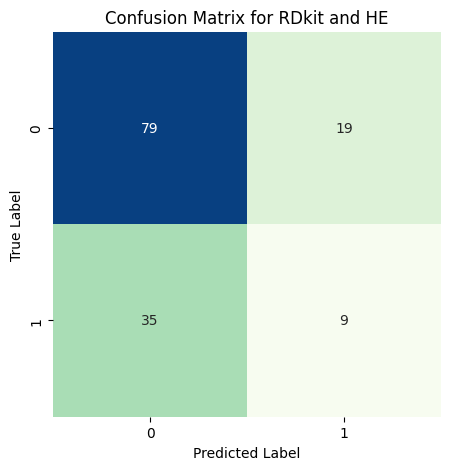

>0.630
>0.704
>0.693
>0.624
>0.683
>0.667
>0.693
>0.656
>0.656
>0.661
>0.661
>0.688
>0.608
>0.677
>0.698
Accuracy: 0.667 (0.028)


2024-11-24 18:23:41.968828: W tensorflow/core/data/root_dataset.cc:362] Optimization loop failed: CANCELLED: Operation was cancelled
2024-11-24 18:43:42.557709: W tensorflow/core/data/root_dataset.cc:362] Optimization loop failed: CANCELLED: Operation was cancelled


Best hyperparameters for RDkit and RES:
dense-bot: 384
dense_activation: relu
num_dense_layers: 1
dense_0: 398
act_l1: relu
dropout_0: 0.1
Optimizer: Adam
learning_rate: 0.1
dense_1: 272
dropout_1: 0.1
dense_2: 298
dropout_2: 0.1
batch_size: 152
dense_3: 220
dropout_3: 0.0
dense_4: 278
dropout_4: 0.0


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 384)            │        76,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 398)            │       153,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 398)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           399 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,661 (897.11 KB)

 Trainable params: 229,661 (897.11 KB)

 Non-trainable params: 0 (0.00 B)

Saved model for RDkit and RES to best_QSARmodel_RDkit_RES.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8392 - loss: 0.3810  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8437 - loss: 0.3792 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8623 - loss: 0.3969 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8653 - loss: 0.3763 
Binary-accuracy score for RDkit and RES:
Binary-accuracy score for training set: 0.84
Binary-accuracy score for test set: 0.86
Binary-accuracy score for valid set: 0.86
Binary-accuracy score for whole data set: 0.84
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Saved confusion matrix plot for RDkit and RES to QSARconfusion_matrix_RDkit_RES.png


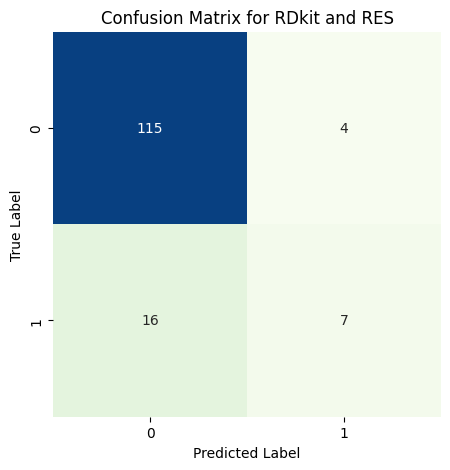

>0.841
>0.852
>0.873
>0.841
>0.815
>0.884
>0.873
>0.810
>0.815
>0.841
>0.841
>0.857
>0.820
>0.825
>0.878
Accuracy: 0.844 (0.024)
Best hyperparameters for RDkit and U:
dense-bot: 800
dense_activation: relu
num_dense_layers: 2
dense_0: 84
act_l1: relu
dropout_0: 0.1
Optimizer: Adam
learning_rate: 1e-05
dense_1: 144
dropout_1: 0.0
dense_2: 42
dropout_2: 0.5
batch_size: 132
dense_3: 54
dropout_3: 0.2
dense_4: 340
dropout_4: 0.5


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 800)            │       158,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        67,284 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 144)            │        12,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,069 (929.96 KB)

 Trainable params: 238,069 (929.96 KB)

 Non-trainable params: 0 (0.00 B)

Saved model for RDkit and U to best_QSARmodel_RDkit_U.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8515 - loss: 0.6701  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8711 - loss: 0.6703 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7922 - loss: 0.6738 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8736 - loss: 0.6693 
Binary-accuracy score for RDkit and U:
Binary-accuracy score for training set: 0.84
Binary-accuracy score for test set: 0.88
Binary-accuracy score for valid set: 0.80
Binary-accuracy score for whole data set: 0.84
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Saved confusion matrix plot for RDkit and U to QSARconfusion_matrix_RDkit_U.png


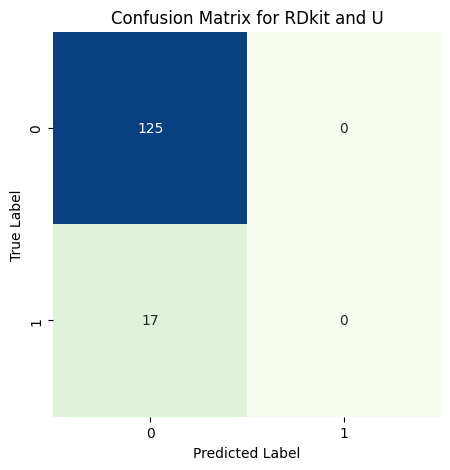

>0.841
>0.836
>0.873
>0.831
>0.820
>0.884
>0.836
>0.810
>0.862
>0.810
>0.841
>0.852
>0.815
>0.852
>0.841
Accuracy: 0.840 (0.021)
Best hyperparameters for ECFP and EN:
dense-bot: 292
dense_activation: relu
num_dense_layers: 1
dense_0: 232
act_l1: tanh
dropout_0: 0.3
Optimizer: SGD
learning_rate: 0.1
dense_1: 132
dropout_1: 0.1
dense_2: 426
dropout_2: 0.2
batch_size: 202
dense_3: 150
dropout_3: 0.5
dense_4: 184
dropout_4: 0.3


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 292)            │       299,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 232)            │        67,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 232)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           233 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 367,509 (1.40 MB)

 Trainable params: 367,509 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for ECFP and EN to best_QSARmodel_ECFP_EN.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9637 - loss: 0.0993  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8446 - loss: 0.5337 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8455 - loss: 0.4551 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9433 - loss: 0.2073 
Binary-accuracy score for ECFP and EN:
Binary-accuracy score for training set: 0.97
Binary-accuracy score for test set: 0.85
Binary-accuracy score for valid set: 0.85
Binary-accuracy score for whole data set: 0.93
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Saved confusion matrix plot for ECFP and EN to QSARconfusion_matrix_ECFP_EN.png


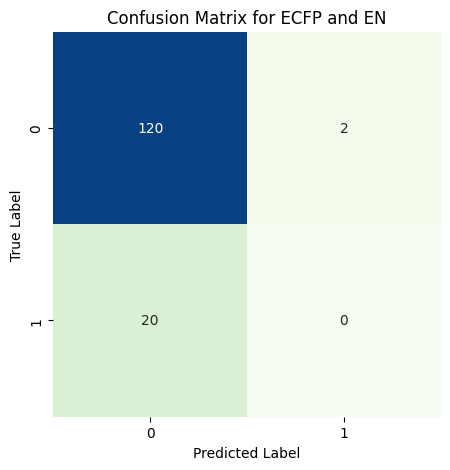

>0.815
>0.931
>0.968
>0.958
>0.979
>0.931
>0.937
>0.931
>0.910
>0.942
>0.952
>0.963
>0.910
>0.931
>0.894
Accuracy: 0.930 (0.038)
Best hyperparameters for ECFP and EX:
dense-bot: 916
dense_activation: relu
num_dense_layers: 2
dense_0: 104
act_l1: tanh
dropout_0: 0.0
Optimizer: SGD
learning_rate: 0.1
dense_1: 474
dropout_1: 0.5
dense_2: 400
dropout_2: 0.3
batch_size: 204
dense_3: 356
dropout_3: 0.0
dense_4: 44
dropout_4: 0.5


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 916)            │       938,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 104)            │        95,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 104)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 474)            │        49,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 474)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,084,513 (4.14 MB)

 Trainable params: 1,084,513 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for ECFP and EX to best_QSARmodel_ECFP_EX.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9552 - loss: 0.1068  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8565 - loss: 0.5527 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8813 - loss: 0.4914 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9416 - loss: 0.2046
Binary-accuracy score for ECFP and EX:
Binary-accuracy score for training set: 0.94
Binary-accuracy score for test set: 0.85
Binary-accuracy score for valid set: 0.89
Binary-accuracy score for whole data set: 0.92
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Saved confusion matrix plot for ECFP and EX to QSARconfusion_matrix_ECFP_EX.png


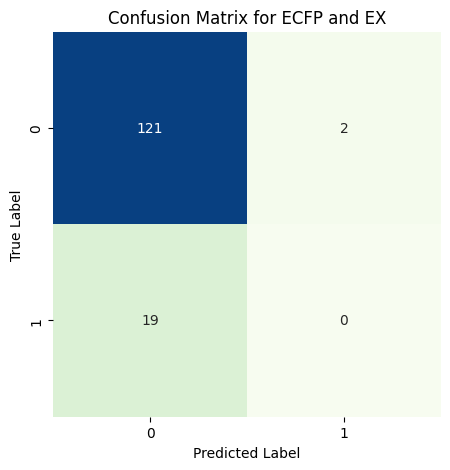

>0.862
>0.926
>0.947
>0.931
>0.931
>0.915
>0.921
>0.926
>0.915
>0.921
>0.921
>0.899
>0.926
>0.926
>0.926
Accuracy: 0.920 (0.018)
Best hyperparameters for ECFP and HE:
dense-bot: 384
dense_activation: relu
num_dense_layers: 1
dense_0: 398
act_l1: relu
dropout_0: 0.1
Optimizer: Adam
learning_rate: 0.1
dense_1: 272
dropout_1: 0.1
dense_2: 298
dropout_2: 0.1
batch_size: 152
dense_3: 220
dropout_3: 0.0
dense_4: 278
dropout_4: 0.0


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 384)            │       393,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 398)            │       153,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 398)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           399 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 547,229 (2.09 MB)

 Trainable params: 547,229 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for ECFP and HE to best_QSARmodel_ECFP_HE.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8655 - loss: 0.3248  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6741 - loss: 1.5412 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6444 - loss: 1.0757 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8199 - loss: 0.6653 
Binary-accuracy score for ECFP and HE:
Binary-accuracy score for training set: 0.85
Binary-accuracy score for test set: 0.69
Binary-accuracy score for valid set: 0.63
Binary-accuracy score for whole data set: 0.80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Saved confusion matrix plot for ECFP and HE to QSARconfusion_matrix_ECFP_HE.png


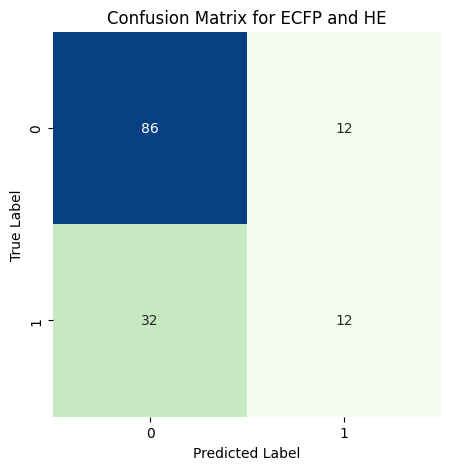

>0.646
>0.783
>0.873
>0.841
>0.836
>0.810
>0.815
>0.767
>0.799
>0.788
>0.799
>0.847
>0.772
>0.794
>0.767
Accuracy: 0.796 (0.050)
Best hyperparameters for ECFP and RES:
dense-bot: 314
dense_activation: tanh
num_dense_layers: 1
dense_0: 268
act_l1: sigmoid
dropout_0: 0.0
Optimizer: SGD
learning_rate: 0.1
dense_1: 220
dropout_1: 0.0
dense_2: 126
dropout_2: 0.0
batch_size: 116
dense_3: 470
dropout_3: 0.2
dense_4: 396
dropout_4: 0.1


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 314)            │       321,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 268)            │        84,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 268)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           269 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,539 (1.55 MB)

 Trainable params: 406,539 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for ECFP and RES to best_QSARmodel_ECFP_RES.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8321 - loss: 0.3568  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8452 - loss: 0.3667 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8660 - loss: 0.4118 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8607 - loss: 0.3431 
Binary-accuracy score for ECFP and RES:
Binary-accuracy score for training set: 0.83
Binary-accuracy score for test set: 0.85
Binary-accuracy score for valid set: 0.87
Binary-accuracy score for whole data set: 0.84
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Saved confusion matrix plot for ECFP and RES to QSARconfusion_matrix_ECFP_RES.png


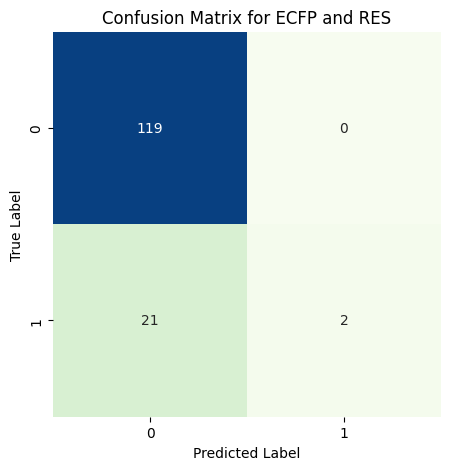

>0.852
>0.841
>0.868
>0.815
>0.810
>0.857
>0.862
>0.804
>0.825
>0.836
>0.847
>0.841
>0.804
>0.820
>0.873
Accuracy: 0.837 (0.022)
Best hyperparameters for ECFP and U:
dense-bot: 916
dense_activation: relu
num_dense_layers: 2
dense_0: 104
act_l1: tanh
dropout_0: 0.0
Optimizer: SGD
learning_rate: 0.1
dense_1: 474
dropout_1: 0.5
dense_2: 400
dropout_2: 0.3
batch_size: 204
dense_3: 356
dropout_3: 0.0
dense_4: 44
dropout_4: 0.5


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 916)            │       938,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 104)            │        95,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 104)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 474)            │        49,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 474)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,084,513 (4.14 MB)

 Trainable params: 1,084,513 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for ECFP and U to best_QSARmodel_ECFP_U.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9244 - loss: 0.1772  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8461 - loss: 0.4445 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8129 - loss: 0.6254 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9065 - loss: 0.2712 
Binary-accuracy score for ECFP and U:
Binary-accuracy score for training set: 0.91
Binary-accuracy score for test set: 0.85
Binary-accuracy score for valid set: 0.81
Binary-accuracy score for whole data set: 0.89
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Saved confusion matrix plot for ECFP and U to QSARconfusion_matrix_ECFP_U.png


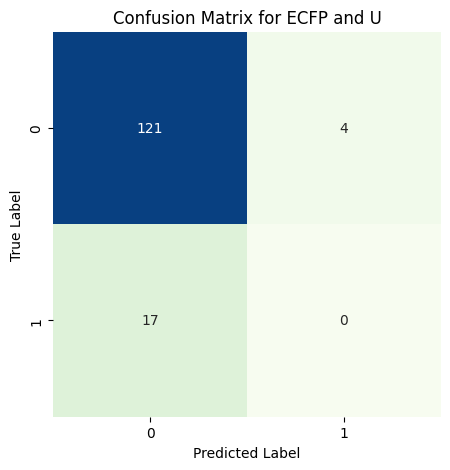

>0.831
>0.889
>0.915
>0.905
>0.905
>0.915
>0.894
>0.862
>0.899
>0.873
>0.878
>0.878
>0.862
>0.910
>0.915
Accuracy: 0.889 (0.024)
Best hyperparameters for FCFP and EN:
dense-bot: 716
dense_activation: tanh
num_dense_layers: 2
dense_0: 354
act_l1: tanh
dropout_0: 0.3
Optimizer: Adam
learning_rate: 1e-06
dense_1: 362
dropout_1: 0.1
dense_2: 502
dropout_2: 0.5
batch_size: 46
dense_3: 478
dropout_3: 0.2
dense_4: 434
dropout_4: 0.1


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 716)            │       733,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 354)            │       253,818 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 354)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 362)            │       128,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 362)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,116,591 (4.26 MB)

 Trainable params: 1,116,591 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

Saved model for FCFP and EN to best_QSARmodel_FCFP_EN.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8616 - loss: 0.5482  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8234 - loss: 0.5661 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8339 - loss: 0.5580 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8629 - loss: 0.5545 
Binary-accuracy score for FCFP and EN:
Binary-accuracy score for training set: 0.84
Binary-accuracy score for test set: 0.83
Binary-accuracy score for valid set: 0.83
Binary-accuracy score for whole data set: 0.84
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Saved confusion matrix plot for FCFP and EN to QSARconfusion_matrix_FCFP_EN.png


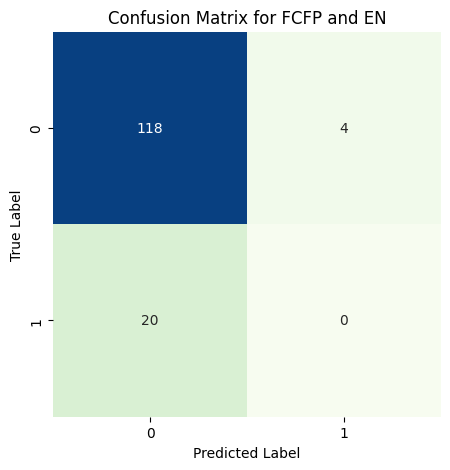

>0.810
>0.878
>0.852
>0.799
>0.841
>0.847
>0.825
>0.836
>0.841
>0.831
>0.889
>0.889
>0.804
>0.804
>0.794
Accuracy: 0.836 (0.030)
Best hyperparameters for FCFP and EX:
dense-bot: 104
dense_activation: relu
num_dense_layers: 2
dense_0: 436
act_l1: relu
dropout_0: 0.5
Optimizer: SGD
learning_rate: 1e-05
dense_1: 224
dropout_1: 0.5
dense_2: 148
dropout_2: 0.1
batch_size: 248
dense_3: 284
dropout_3: 0.2
dense_4: 94
dropout_4: 0.5


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 104)            │       106,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 436)            │        45,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 436)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 224)            │        97,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,493 (978.49 KB)

 Trainable params: 250,493 (978.49 KB)

 Non-trainable params: 0 (0.00 B)

Saved model for FCFP and EX to best_QSARmodel_FCFP_EX.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8875 - loss: 0.6503  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8576 - loss: 0.6561 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8624 - loss: 0.6527 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9023 - loss: 0.6497 
Binary-accuracy score for FCFP and EX:
Binary-accuracy score for training set: 0.87
Binary-accuracy score for test set: 0.86
Binary-accuracy score for valid set: 0.88
Binary-accuracy score for whole data set: 0.87
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Saved confusion matrix plot for FCFP and EX to QSARconfusion_matrix_FCFP_EX.png


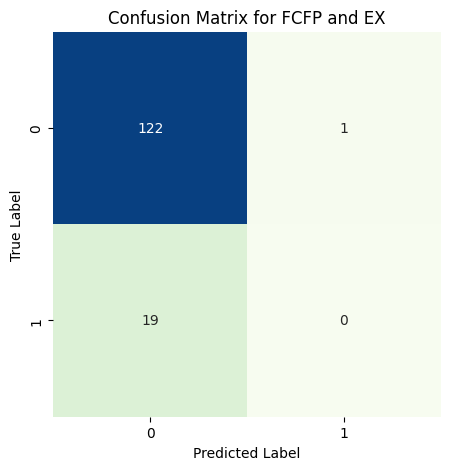

>0.862
>0.894
>0.884
>0.841
>0.884
>0.894
>0.884
>0.873
>0.862
>0.852
>0.852
>0.862
>0.857
>0.889
>0.905
Accuracy: 0.873 (0.018)
Best hyperparameters for FCFP and HE:
dense-bot: 190
dense_activation: relu
num_dense_layers: 2
dense_0: 80
act_l1: relu
dropout_0: 0.1
Optimizer: SGD
learning_rate: 0.1
dense_1: 118
dropout_1: 0.1
dense_2: 402
dropout_2: 0.2
batch_size: 100
dense_3: 450
dropout_3: 0.2
dense_4: 460
dropout_4: 0.5


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 190)            │       194,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 80)             │        15,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 118)            │         9,558 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 118)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,707 (858.23 KB)

 Trainable params: 219,707 (858.23 KB)

 Non-trainable params: 0 (0.00 B)

Saved model for FCFP and HE to best_QSARmodel_FCFP_HE.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9128 - loss: 0.2928  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6537 - loss: 0.6438 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6547 - loss: 0.7736 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.8172 - loss: 0.4391
Binary-accuracy score for FCFP and HE:
Binary-accuracy score for training set: 0.91
Binary-accuracy score for test set: 0.64
Binary-accuracy score for valid set: 0.63
Binary-accuracy score for whole data set: 0.82
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Saved confusion matrix plot for FCFP and HE to QSARconfusion_matrix_FCFP_HE.png


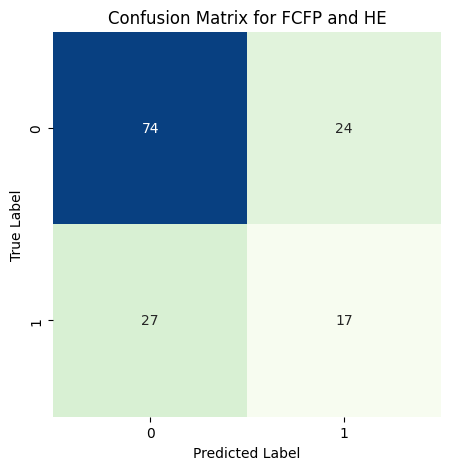

>0.587
>0.831
>0.905
>0.889
>0.910
>0.820
>0.831
>0.836
>0.825
>0.810
>0.799
>0.825
>0.852
>0.841
>0.804
Accuracy: 0.824 (0.072)


In [ ]:
# List of feature types and corresponding labels
feature_types = {"RDkit": X_rdkit, "ECFP": X_ECFP6, "FCFP": X_FCFP6, "MACCS": X_MACCS, "All": X_All}
label_types = {"EN": Yen, "EX": Yex, "HE": Yhe, "RES": Yres, "U": Yu}

# Loop through feature and label combinations
for feature_name, feature_data in feature_types.items():
    for label_name, label_data in label_types.items():

        # Define train-test split for the current feature-label pair
        X_train, X_res, y_train, y_res = train_test_split(feature_data, label_data, train_size=0.7, random_state=42)
        X_valid, X_test, y_valid, y_test = train_test_split(X_res, y_res, test_size=0.5, random_state=42)

        # Initialize the NNHyperModel class with the correct input shape
        input_shape = feature_data.shape[1]
        hypermodel = NNHyperModel(input_shape=input_shape)

        # Define the Bayesian Optimization tuner
        tuner_bo = BayesianOptimization(
            hypermodel,
            objective=kt.Objective('val_accuracy', direction='max'),
            max_trials=50,
            overwrite=True,
            executions_per_trial=3,
            seed=42,
        )

        # Search for the best hyperparameters
        tuner_bo.search(X_train, y_train,
                        validation_data=(X_valid, y_valid),
                        epochs=500, verbose=0,
                        callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=5,
                                                                    restore_best_weights=True)] #Early stopping halts training when the model stops improving, which helps prevent overfitting
        )

        # Get the best hyperparameters
        best_params = tuner_bo.get_best_hyperparameters(num_trials=1)[0]

        # Print the best hyperparameters
        print(f"Best hyperparameters for {feature_name} and {label_name}:")
        for param, value in best_params.values.items():
            print(f"{param}: {value}")

        # Get the best model and print the summary
        best_model = tuner_bo.get_best_models(num_models=1)[0]
        best_model.summary()  # Print model summary

        # Save the model with the actual feature and label names in the filename
        model_filename = f"best_QSARmodel_{feature_name}_{label_name}.keras"
        best_model.save(model_filename)
        print(f"Saved model for {feature_name} and {label_name} to {model_filename}")


        # Evaluate the model on the training, test, validation, and whole datasets
        _, acc_train = best_model.evaluate(X_train, y_train)
        _, acc_test  = best_model.evaluate(X_test, y_test)
        _, acc_valid = best_model.evaluate(X_valid, y_valid)
        _, acc_whole = best_model.evaluate(feature_data, label_data)  # Fixed here

        # Print the results
        print(f"Binary-accuracy score for {feature_name} and {label_name}:")
        print("Binary-accuracy score for training set: %.2f" % acc_train)
        print("Binary-accuracy score for test set: %.2f" % acc_test)
        print("Binary-accuracy score for valid set: %.2f" % acc_valid)
        print("Binary-accuracy score for whole data set: %.2f" % acc_whole)


        # Predict the labels for the test data
        y_pred = (best_model.predict(X_test) > 0.5).astype("int32")  # Binary classification threshold

        # Calculate the confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot the confusion matrix using seaborn heatmap
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu', cbar=False)
        plt.title(f'Confusion Matrix for {feature_name} and {label_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        # Save the plot
        plot_filename = f"QSARconfusion_matrix_{feature_name}_{label_name}.png"
        plt.savefig(plot_filename)
        print(f"Saved confusion matrix plot for {feature_name} and {label_name} to {plot_filename}")
        # Show the plot
        plt.show()

        # Evalaute model
        results = evaluate_model(feature_data, label_data)
        # Summarize performance
        print('Accuracy: %.3f (%.3f)' % (mean(results), std(results)))

In [ ]:
# Path to the folder where model files are saved
model_folder = './Best_QSARmodel'
# Path to save plots
plot_save_folder = './QSARNN_Curves'
os.makedirs(plot_save_folder, exist_ok=True)  # Create the directory if it doesn't exist

# List of feature types and corresponding labels
feature_types = {"RDkit": X_rdkit, "ECFP": X_ECFP6, "FCFP": X_FCFP6, "MACCS": X_MACCS, "All": X_All}
label_types = {"EN": Yen, "EX": Yex, "HE": Yhe, "RES": Yres, "U": Yu}

# Create a list to store metrics
metrics_list = []

In [ ]:
# Loop through feature and label combinations
for feature_name, feature_data in feature_types.items():
    for label_name, label_data in label_types.items():

        # Define train-test split for the current feature-label pair
        X_train, X_res, y_train, y_res = train_test_split(feature_data, label_data, train_size=0.7, random_state=42)
        X_valid, X_test, y_valid, y_test = train_test_split(X_res, y_res, test_size=0.5, random_state=42)

        # Directly map X_train index to the CAS column in df_finalized
        train_indices = df_finalized.loc[X_train.index, 'CAS']
        valid_indices = df_finalized.loc[X_valid.index, 'CAS']
        test_indices = df_finalized.loc[X_test.index, 'CAS']

        # Construct model filename based on feature and label names
        model_filename = f"best_QSARmodel_{feature_name}_{label_name}.keras"
        model_path = os.path.join(model_folder, model_filename)

        # Check if the model file exists before loading
        if os.path.exists(model_path):
            # Load the model
            model = tf.keras.models.load_model(model_path)

            # Make predictions on the training, validation, and test sets
            y_train_pred_prob = model.predict(X_train)
            y_valid_pred_prob = model.predict(X_valid)
            y_test_pred_prob = model.predict(X_test)

            # Convert probabilities to binary predictions
            y_train_pred = (y_train_pred_prob > 0.5).astype("int32")
            y_valid_pred = (y_valid_pred_prob > 0.5).astype("int32")
            y_test_pred = (y_test_pred_prob > 0.5).astype("int32")

            # Calculate metrics for training set
            train_recall = recall_score(y_train, y_train_pred, average='binary')
            train_f1_weighted = f1_score(y_train, y_train_pred, average='weighted')
            train_precision = precision_score(y_train, y_train_pred, average='binary')
            train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
            train_pr_auc = average_precision_score(y_train, y_train_pred_prob)

            # Calculate metrics for validation set
            valid_recall = recall_score(y_valid, y_valid_pred, average='binary')
            valid_f1_weighted = f1_score(y_valid, y_valid_pred, average='weighted')
            valid_precision = precision_score(y_valid, y_valid_pred, average='binary')
            valid_roc_auc = roc_auc_score(y_valid, y_valid_pred_prob)
            valid_pr_auc = average_precision_score(y_valid, y_valid_pred_prob)

            # Calculate metrics for test set
            test_recall = recall_score(y_test, y_test_pred, average='binary')
            test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
            test_precision = precision_score(y_test, y_test_pred, average='binary')
            test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
            test_pr_auc = average_precision_score(y_test, y_test_pred_prob)

            # Append metrics to the list
            metrics_list.append({
                'Model': model_filename,
                'Feature Type': feature_name,
                'Label Type': label_name,
                'Train_chem': train_indices.tolist(),
                'Validation_chem': valid_indices.tolist(),
                'Test_chem': test_indices.tolist(),
                'true Train': y_train.tolist(),
                'true Validation': y_valid.tolist(),
                'true Test': y_test.tolist(),
                'Train prob': y_train_pred_prob.tolist(),
                'Validation prob': y_valid_pred_prob.tolist(),
                'Test prob': y_test_pred_prob.tolist(),
                'Train Recall': train_recall,
                'Train F1 Score (Weighted)': train_f1_weighted,
                'Train Precision': train_precision,
                'Train ROC AUC': train_roc_auc,
                'Validation Recall': valid_recall,
                'Validation F1 Score (Weighted)': valid_f1_weighted,
                'Validation Precision': valid_precision,
                'Validation ROC AUC': valid_roc_auc,
                'Test Recall': test_recall,
                'Test F1 Score (Weighted)': test_f1_weighted,
                'Test Precision': test_precision,
                'Test ROC AUC': test_roc_auc
            })

# Convert the list to a DataFrame and save as CSV
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv('QSARNN_model_metrics.csv', index=False)
metrics_df.info()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

/home/chen.chiyun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chen.chiyun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chen.chiyun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chen.chiyun/.local/lib/py

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

/home/chen.chiyun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
 1/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step

/home/chen.chiyun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

/home/chen.chiyun/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Model                           25 non-null     object 
 1   Feature Type                    25 non-null     object 
 2   Label Type                      25 non-null     object 
 3   Train_chem                      25 non-null     object 
 4   Validation_chem                 25 non-null     object 
 5   Test_chem                       25 non-null     object 
 6   true Train                      25 non-null     object 
 7   true Validation                 25 non-null     object 
 8   true Test                       25 non-null     object 
 9   Train prob                      25 non-null     object 
 10  Validation prob                 25 non-null     object 
 11  Test prob              